In [198]:
import numpy as np
import pandas as pd
import torch
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns 
from itertools import combinations
from sklearn.preprocessing import LabelEncoder
import os
plt.rcParams.update({
    'figure.dpi' : 150
})


In [199]:
test_survived = pd.read_csv('gender_submission.csv')
test_set = pd.read_csv('test.csv')
train_set = pd.read_csv('train.csv')
dfs = [train_set, test_set]

remapper = {
    'Survived' : {
        0 : 'Died',
        1 : 'Survived'
    },
    'Embarked' : {
         'C' : 'Cherbourg', 
         'Q' : 'Queenstown',
         'S' : 'Southampton'
    },
    'Pclass' : {
        1 : 'First class',
        2 : 'Second class',
        3 : 'Third class'
    }
}
[df.replace(remapper, inplace= True) for df in dfs]

total_set = pd.concat(dfs)

# Trying to practice with MultiIndex
dfs = {i : eval(i).reset_index() for i in ['train_set', 'test_set', 'total_set']}
total_df = pd.concat(dfs, axis =0).drop(columns='index').drop(columns=['PassengerId'])

# Meaning of columns:

| Column Name | Meaning | Values |
|---|---|---|
| Survived | If survived | 0 = No, 1 = Yes |
| Pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| Sex | sex | Male / Female |
| Age | Age in years | xx.5 = guess, 0.?? months (float) |
| Sibsp | Number of siblings / spouses aboard | int |
| Parch | Number of parents / children aboard | int | 
| Ticket | Ticket number | string |
| Fare | Passenger fare | float |
| Cabin | Cabin number | string |
| Embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

# (Small) Categorical columns

/tmp/ipykernel_322/185292311.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, len(df_dict), figsize = (5*len(df_dict), 5), sharex=True, sharey=True)


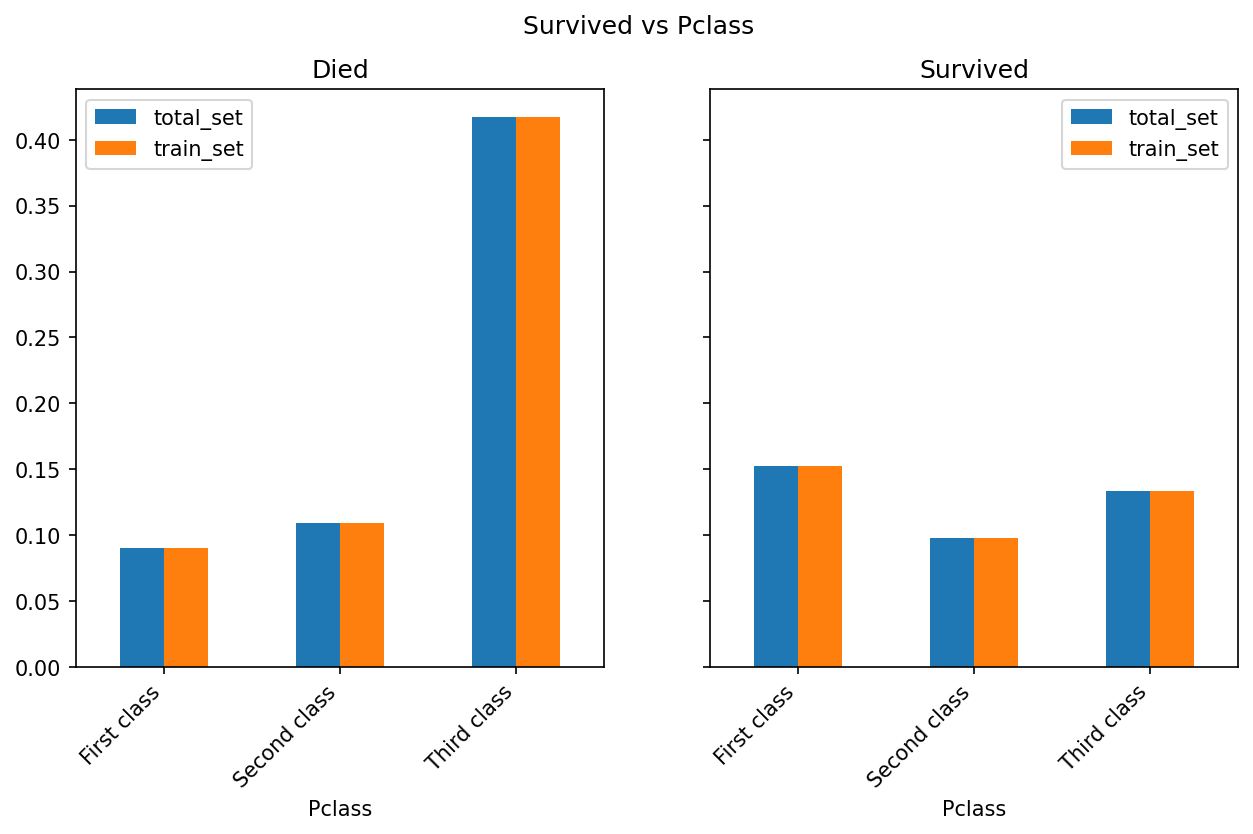

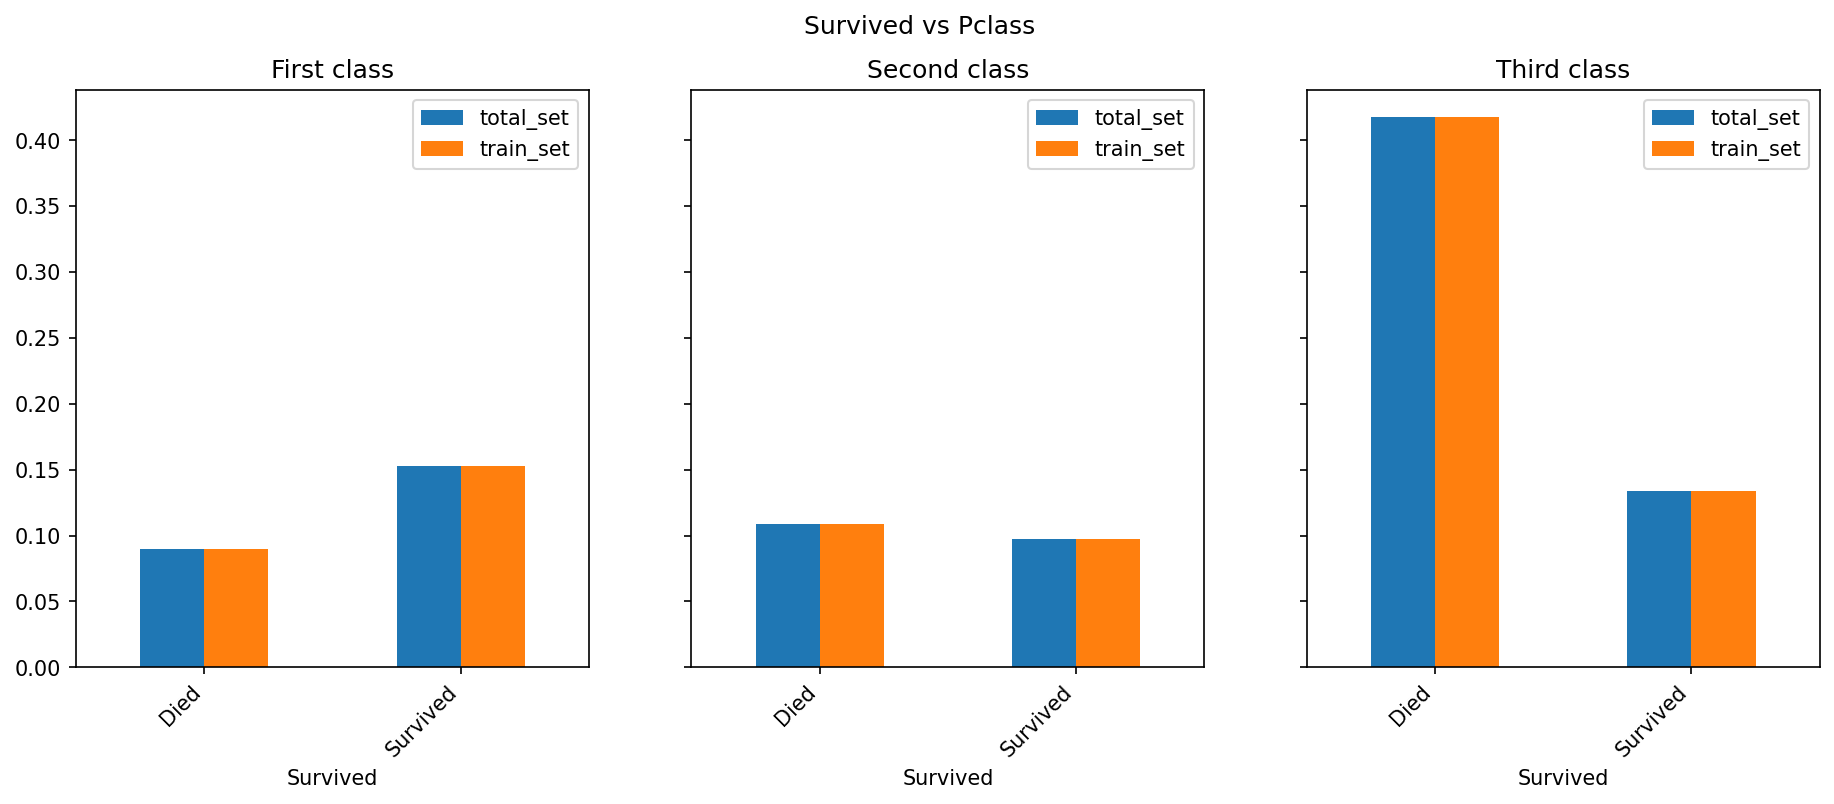

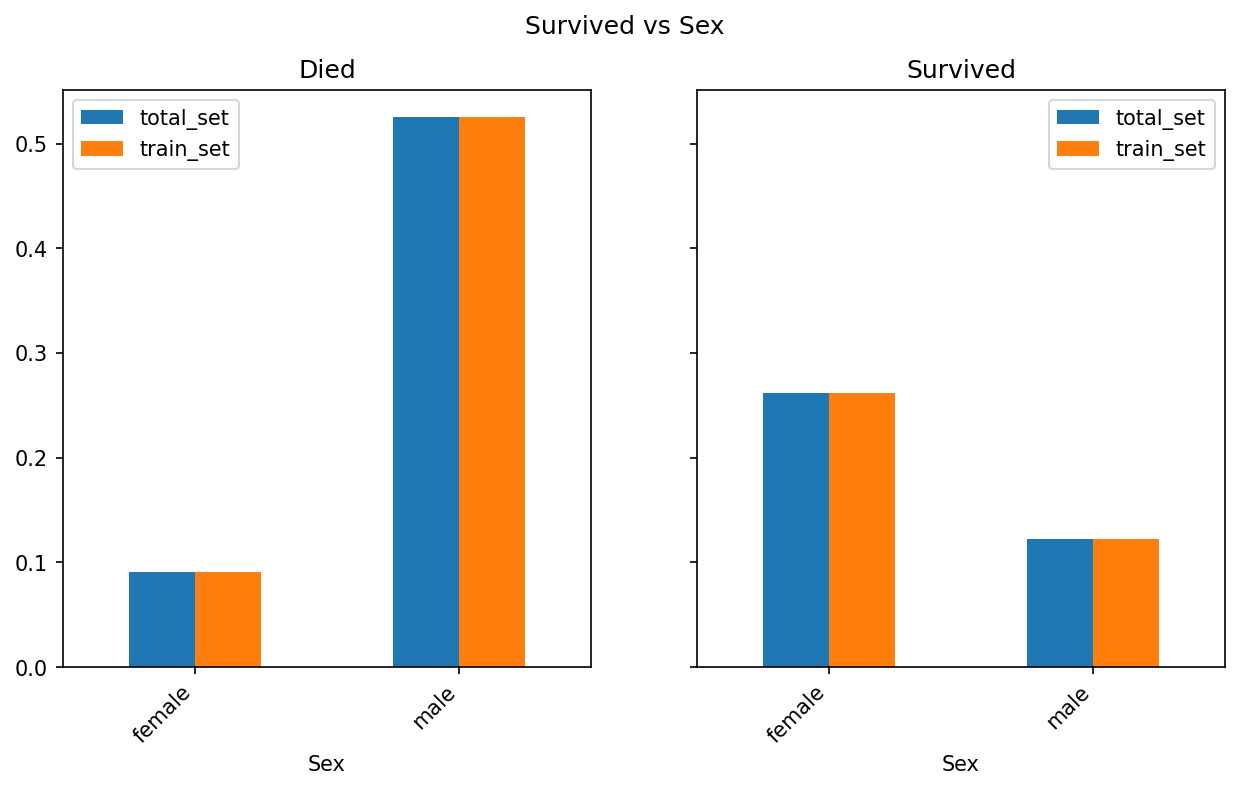

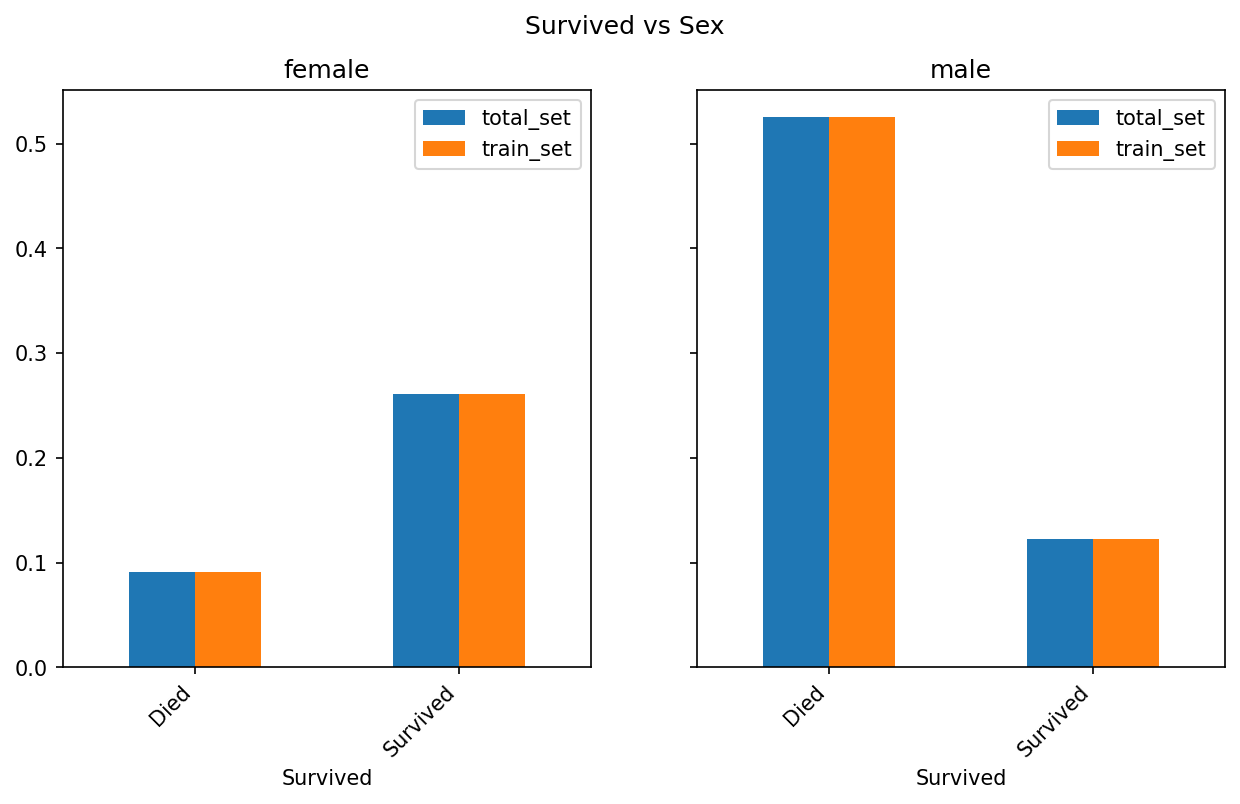

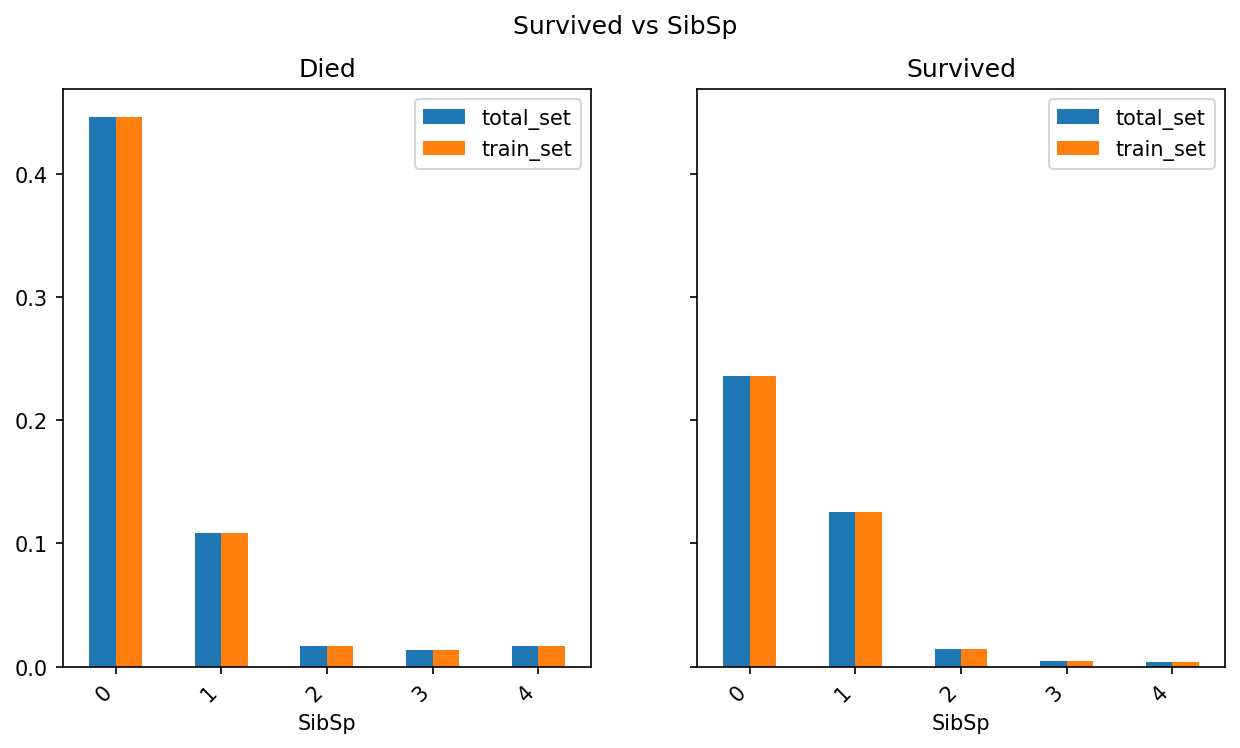

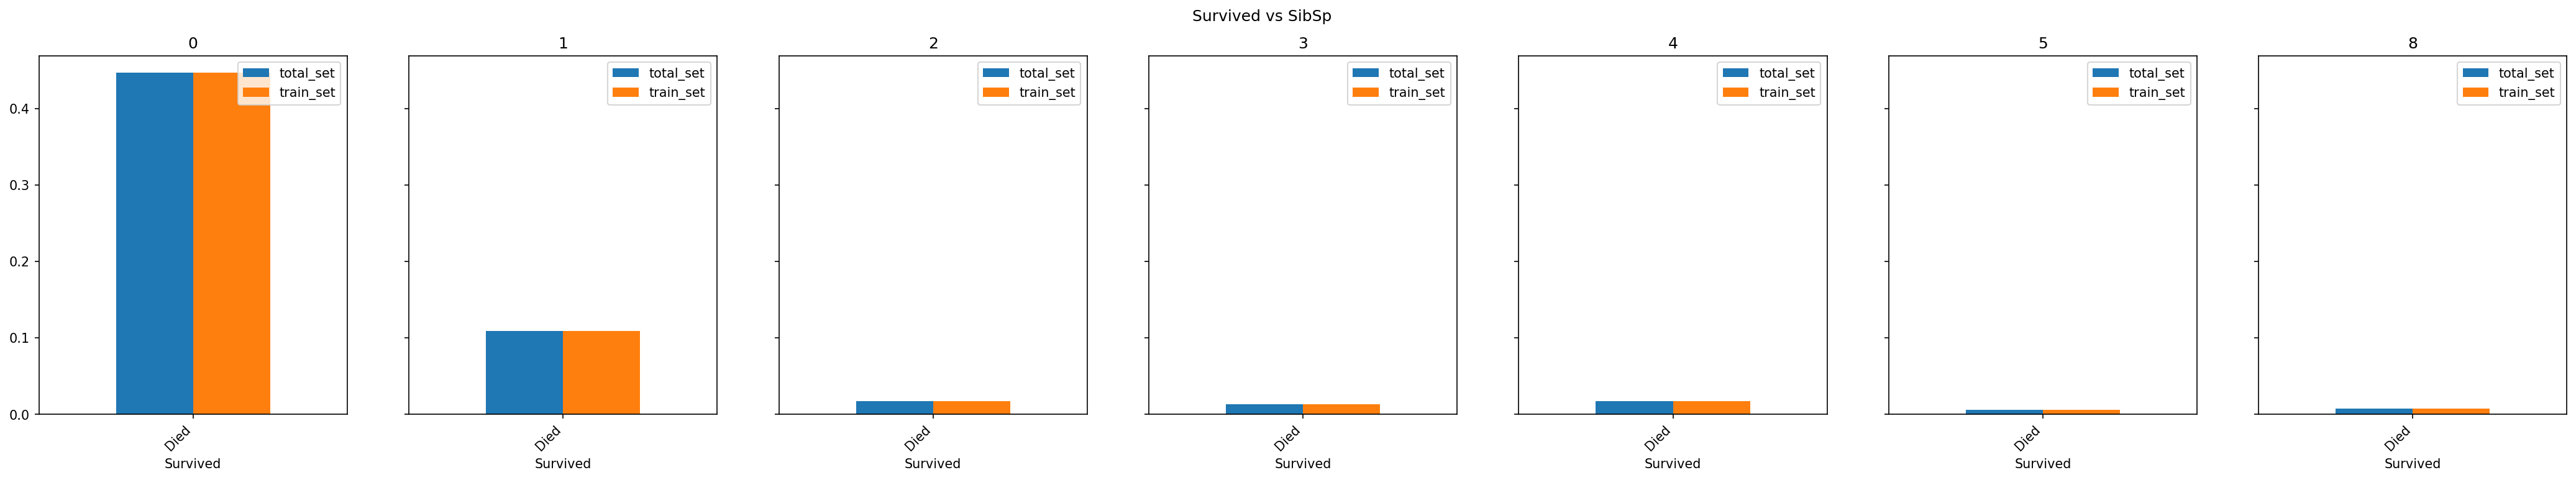

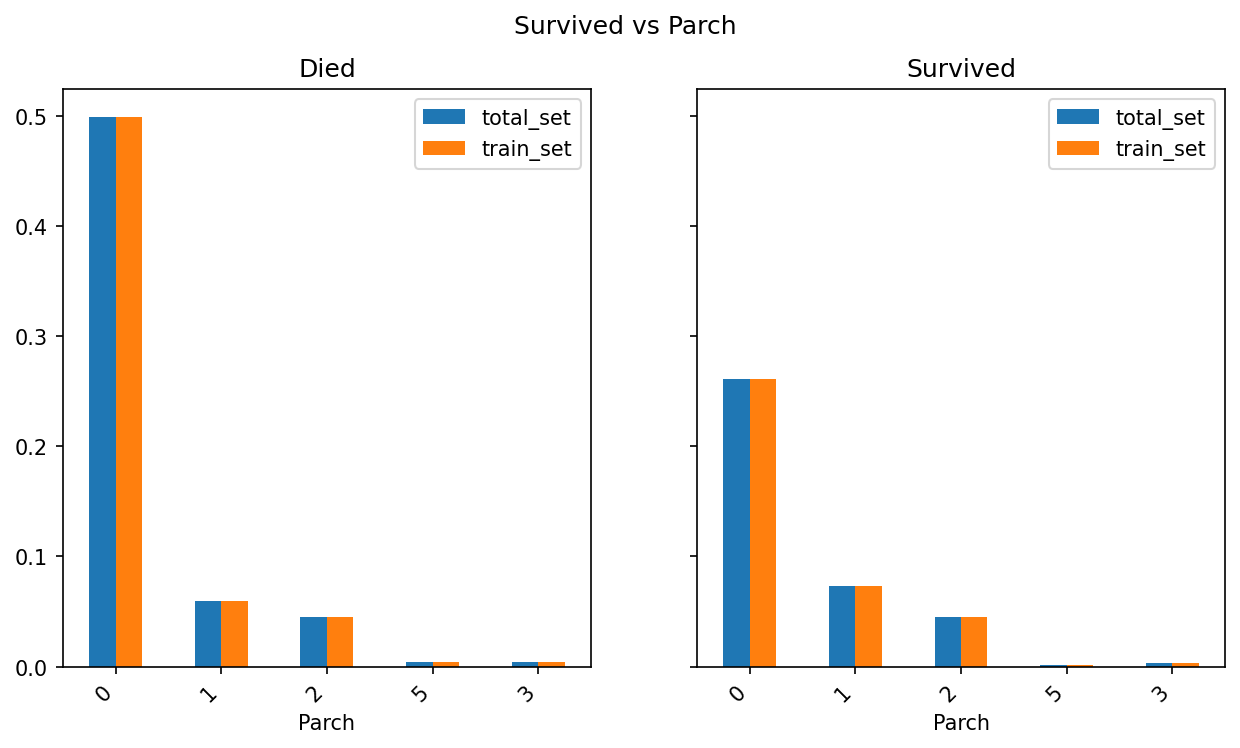

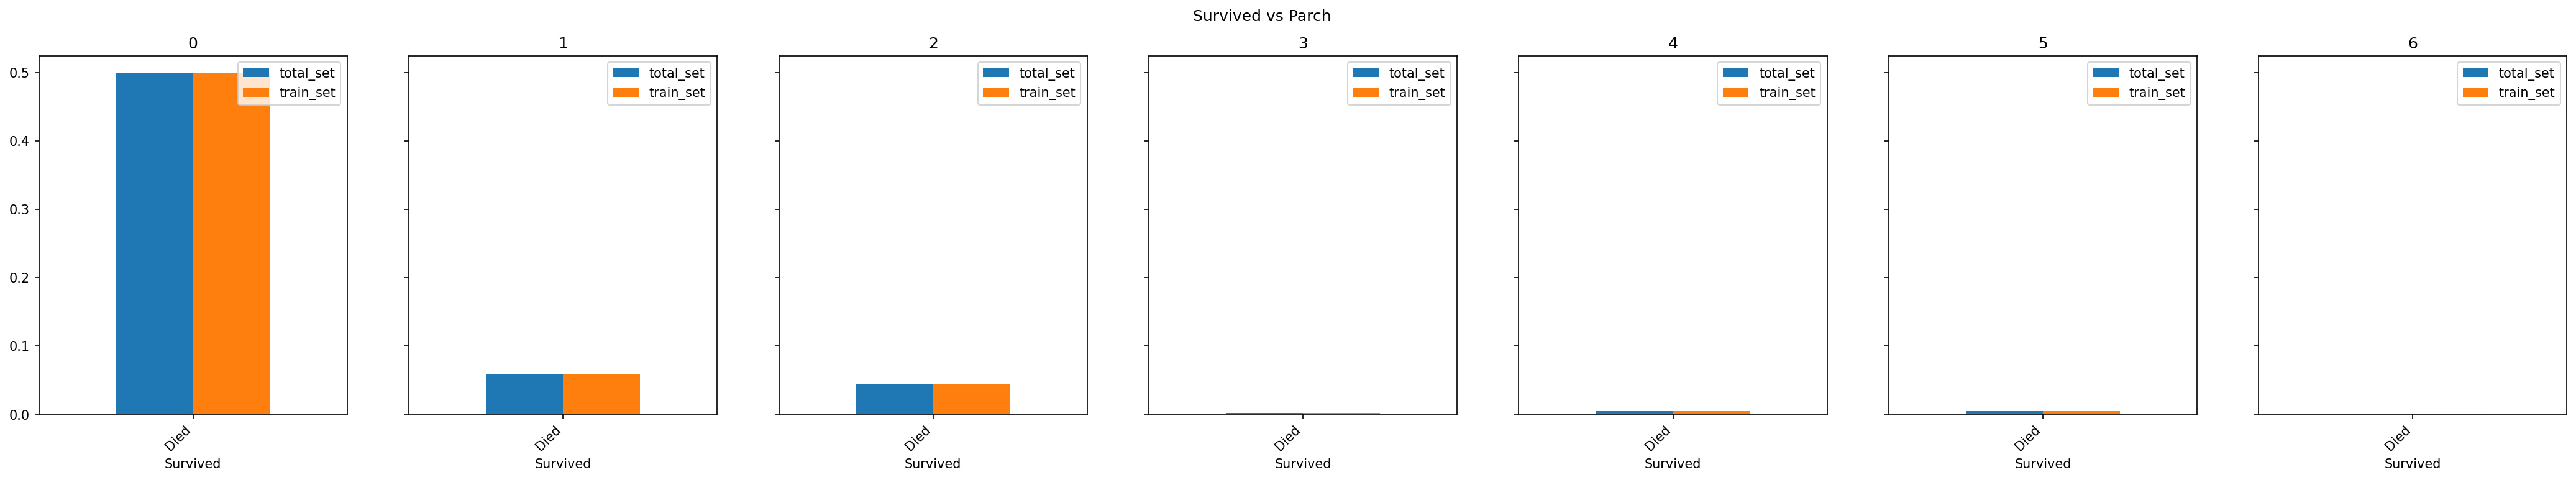

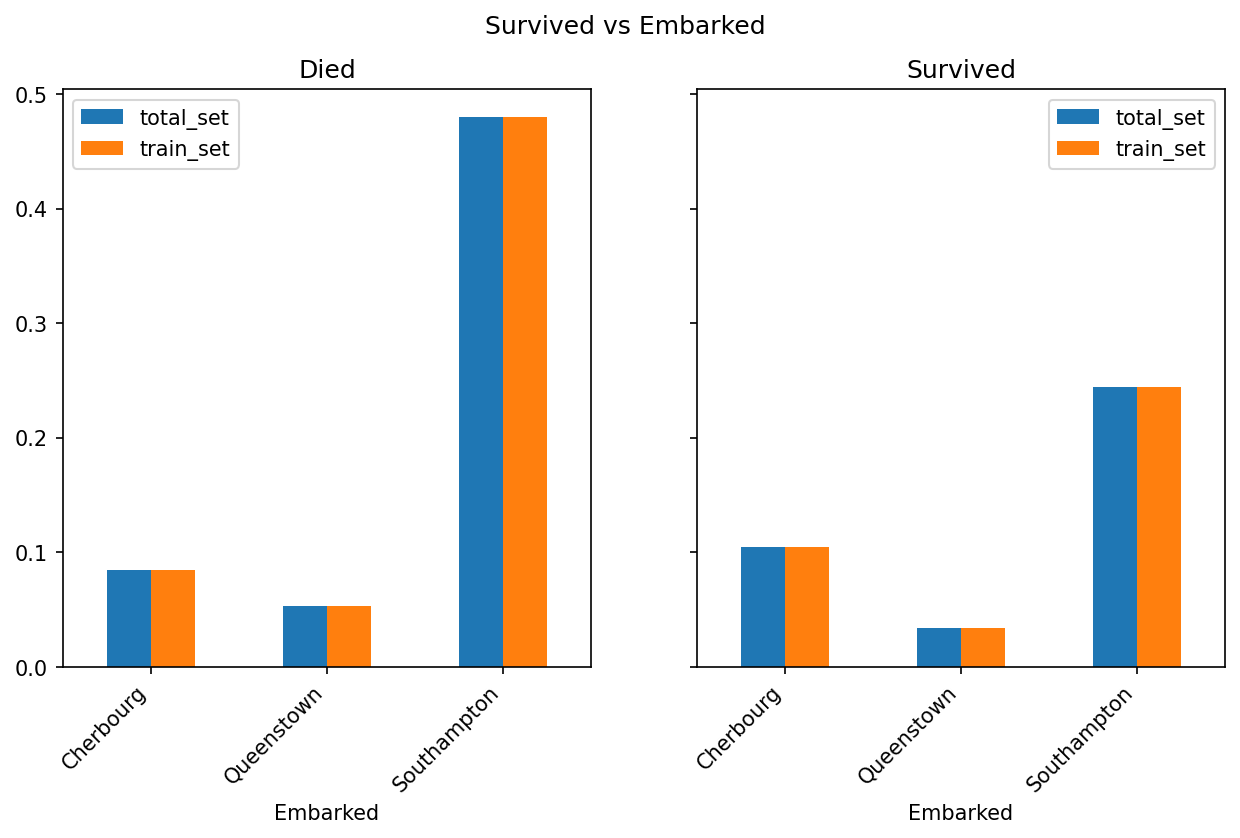

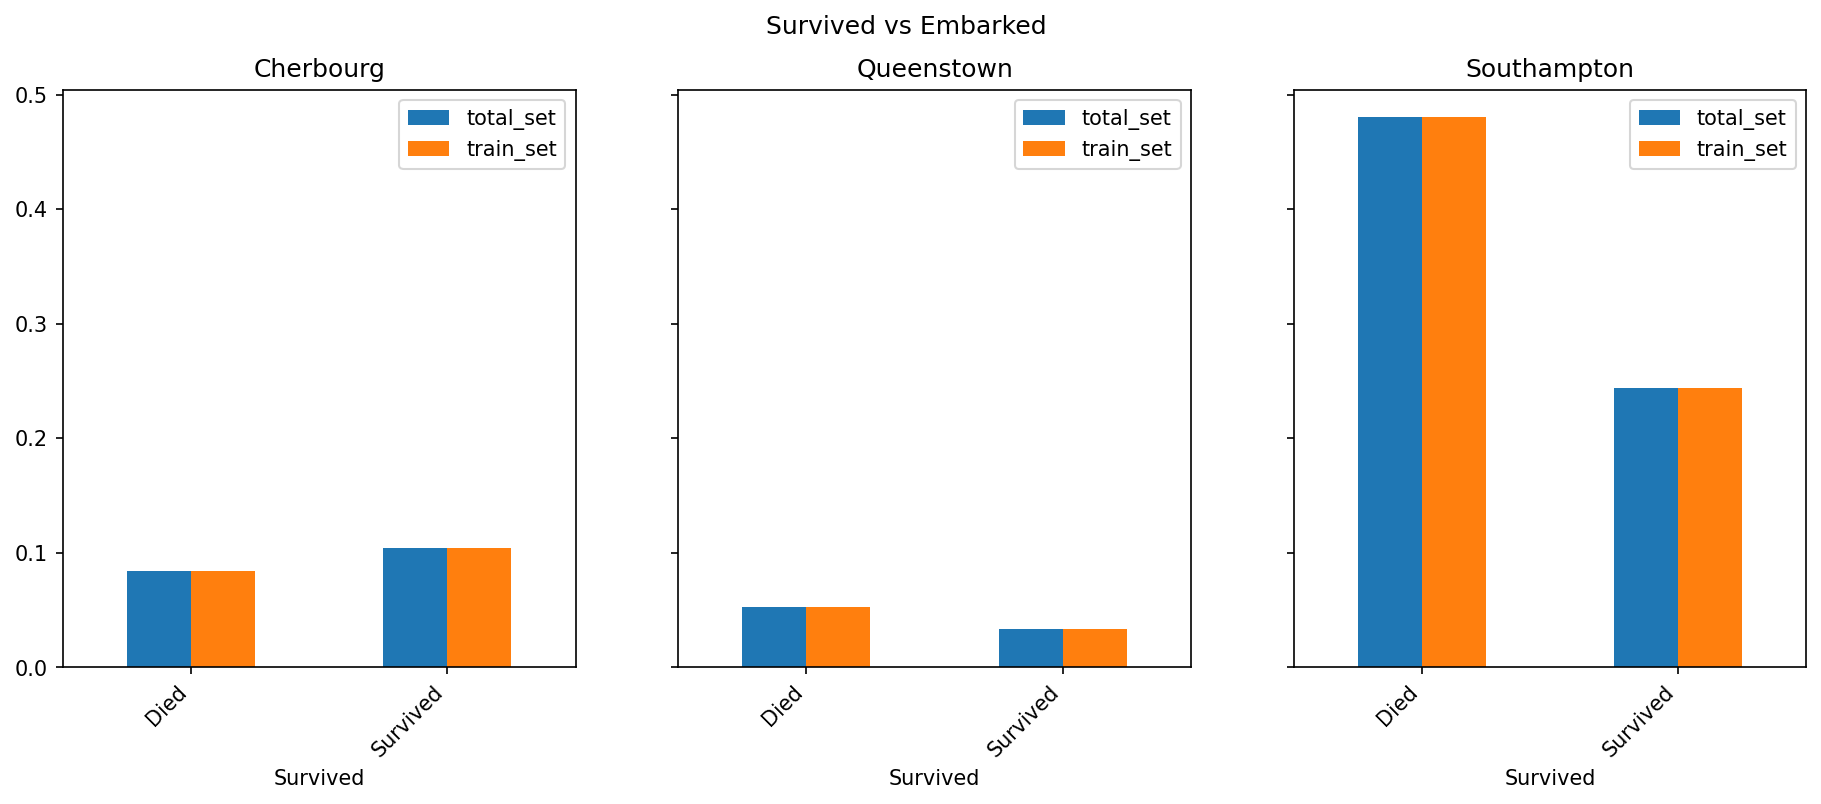

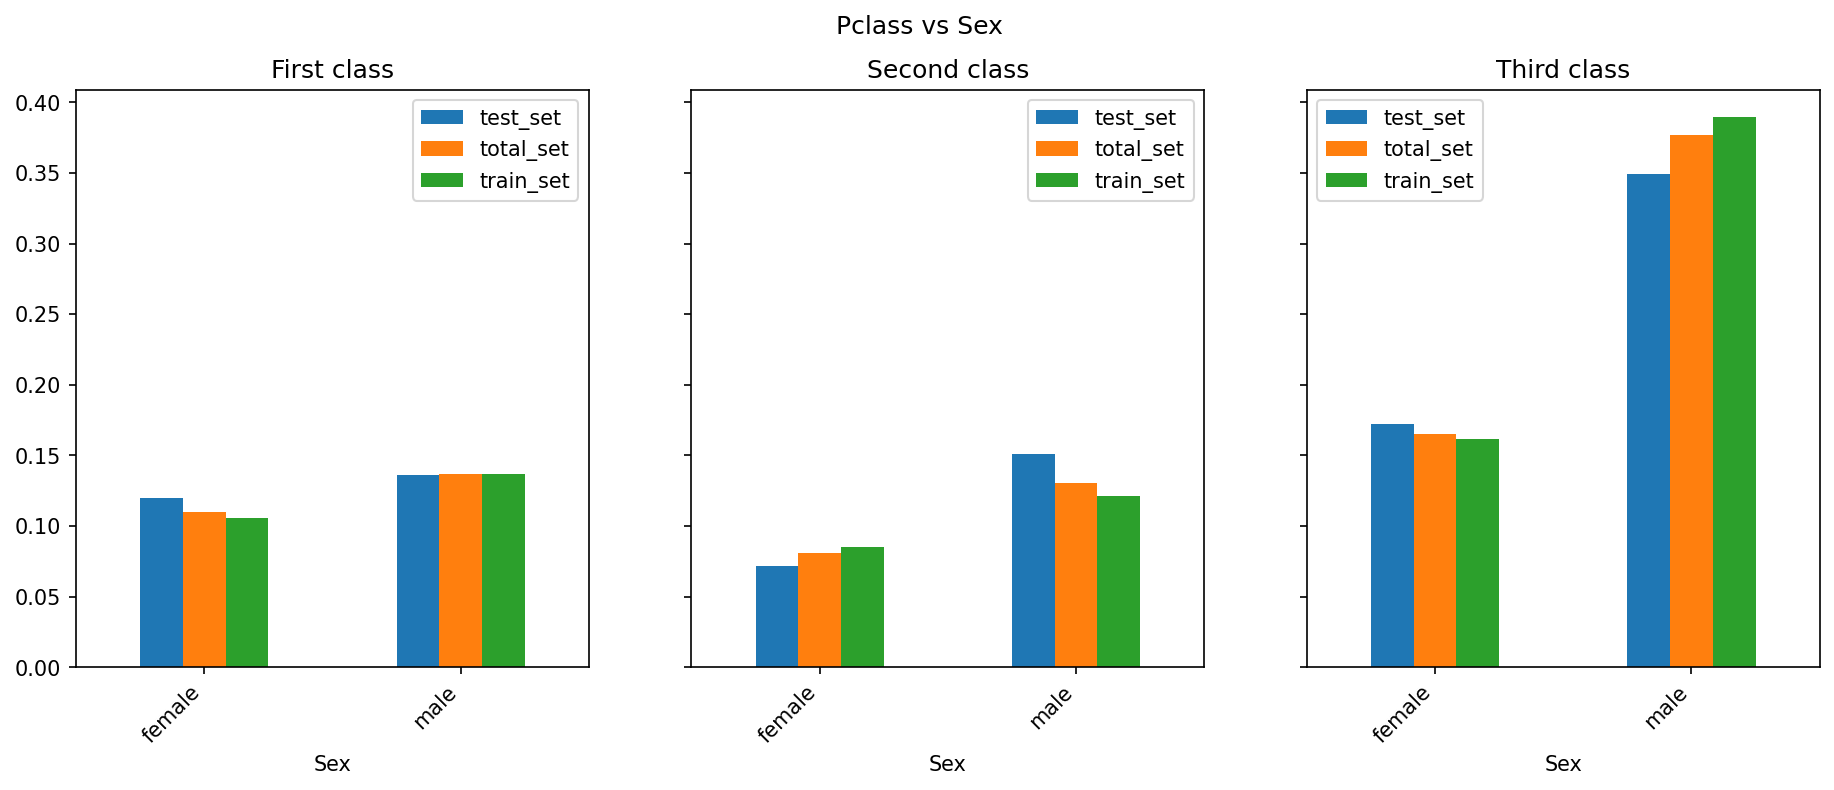

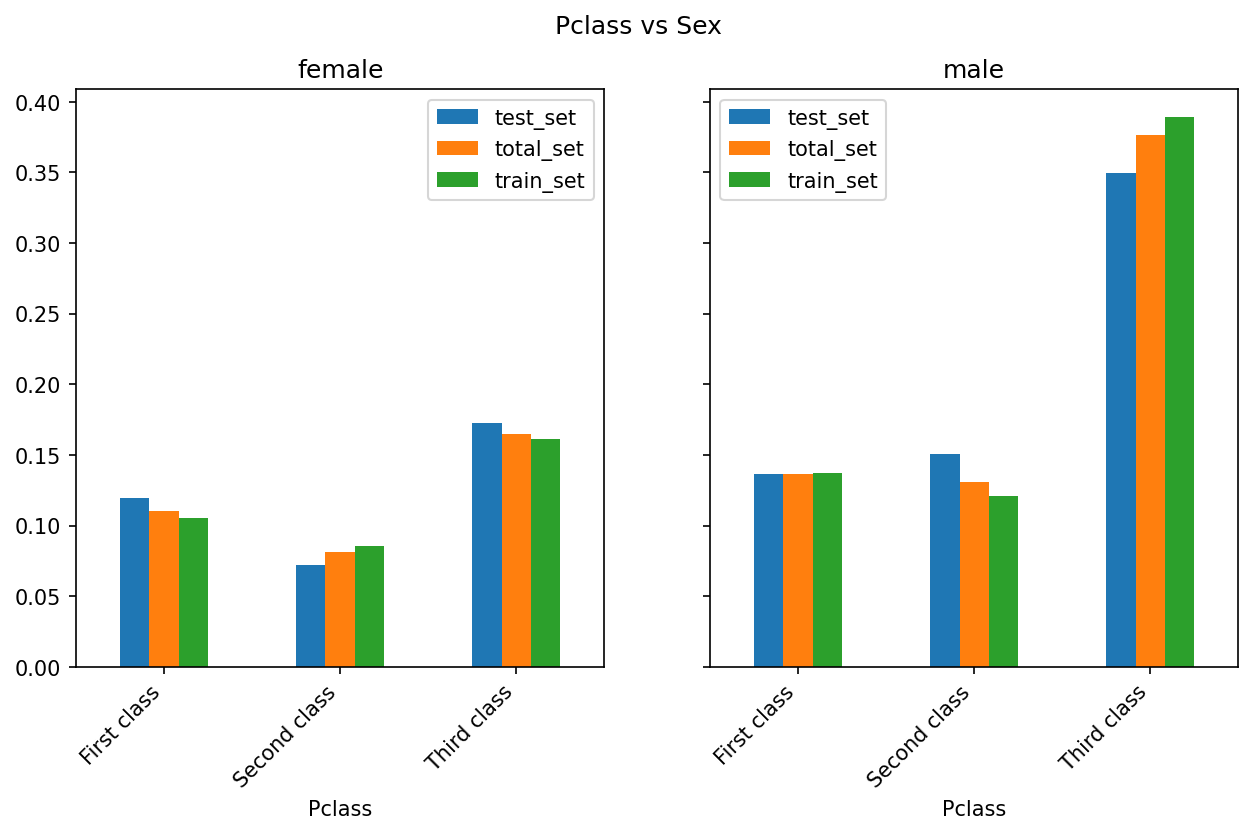

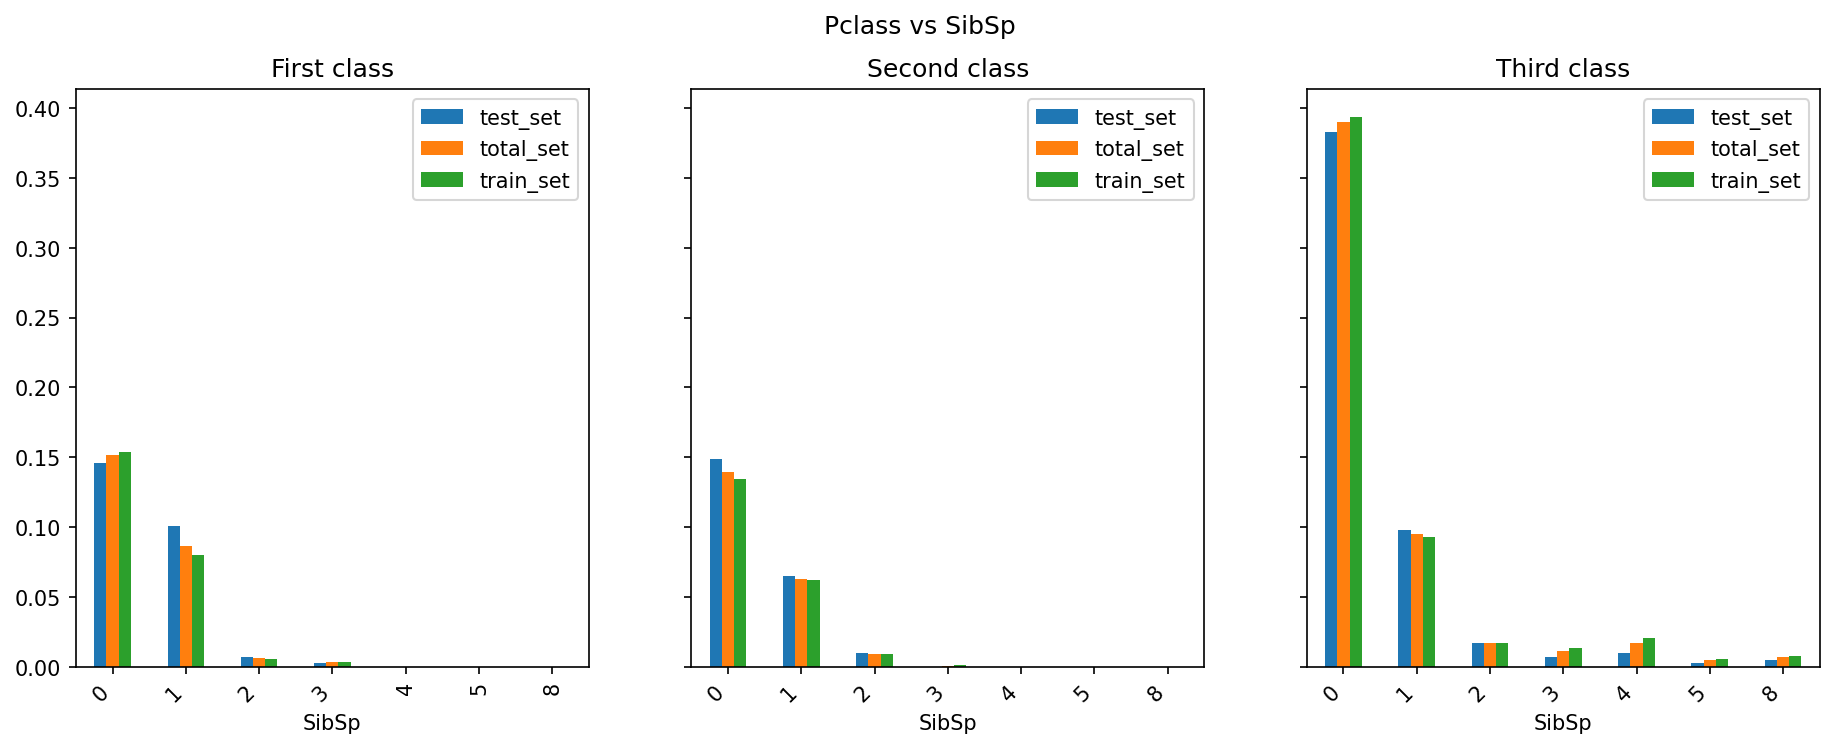

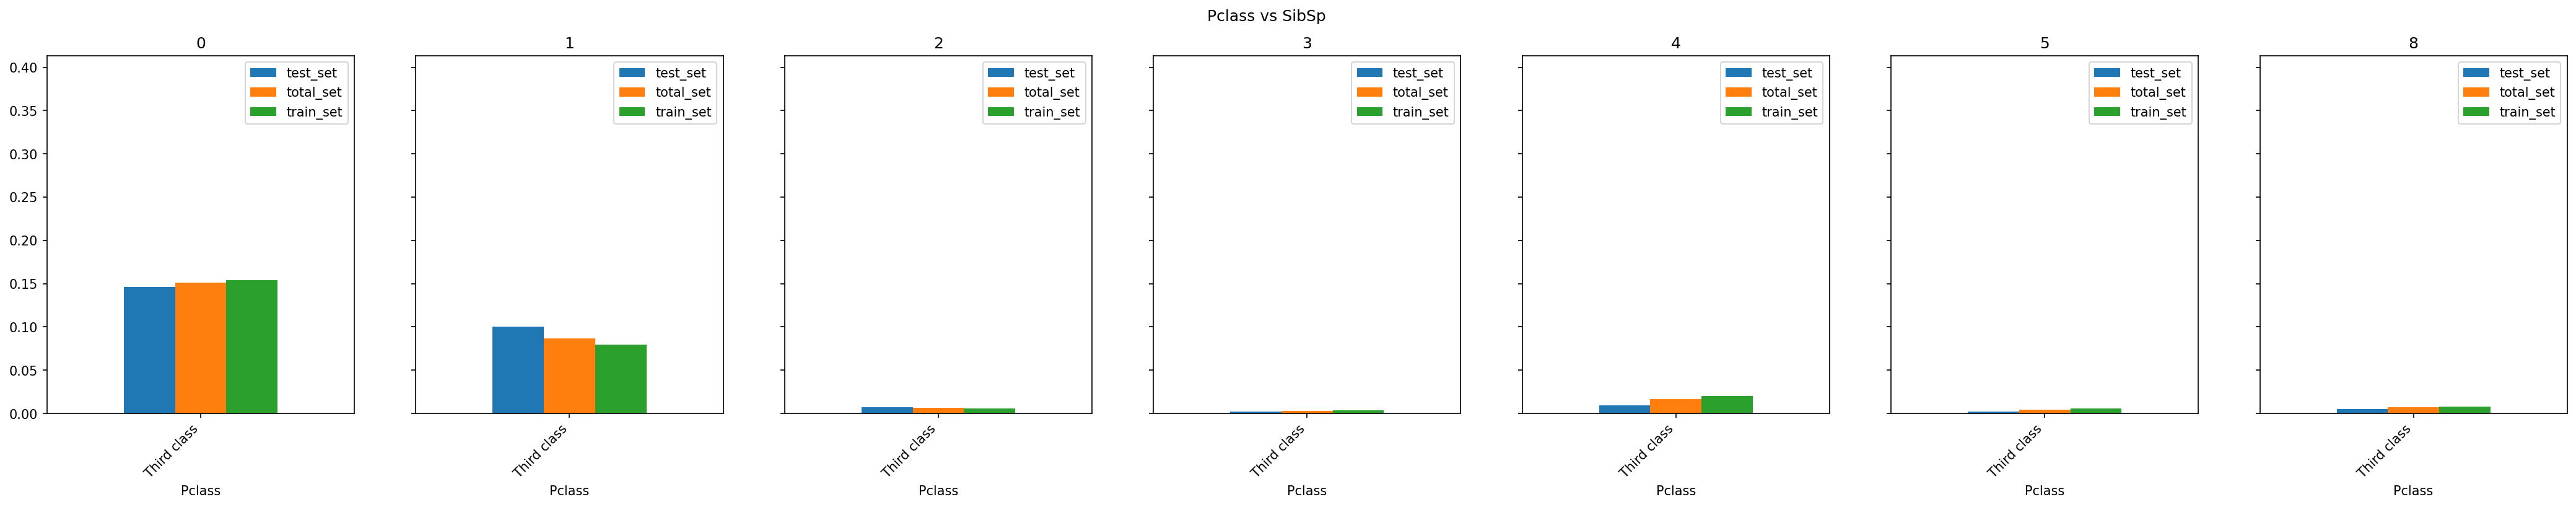

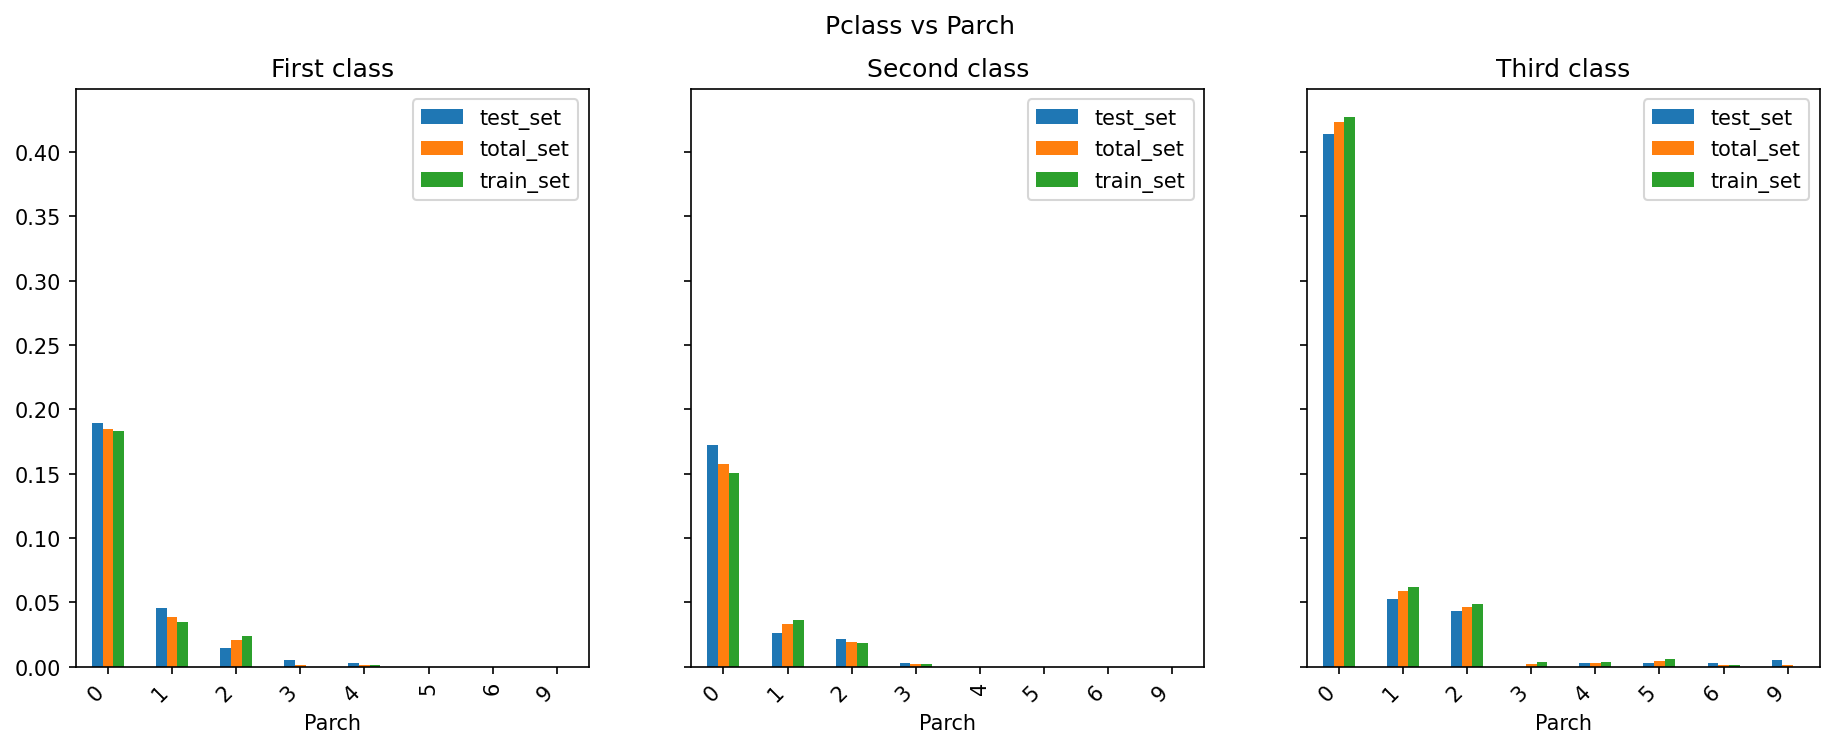

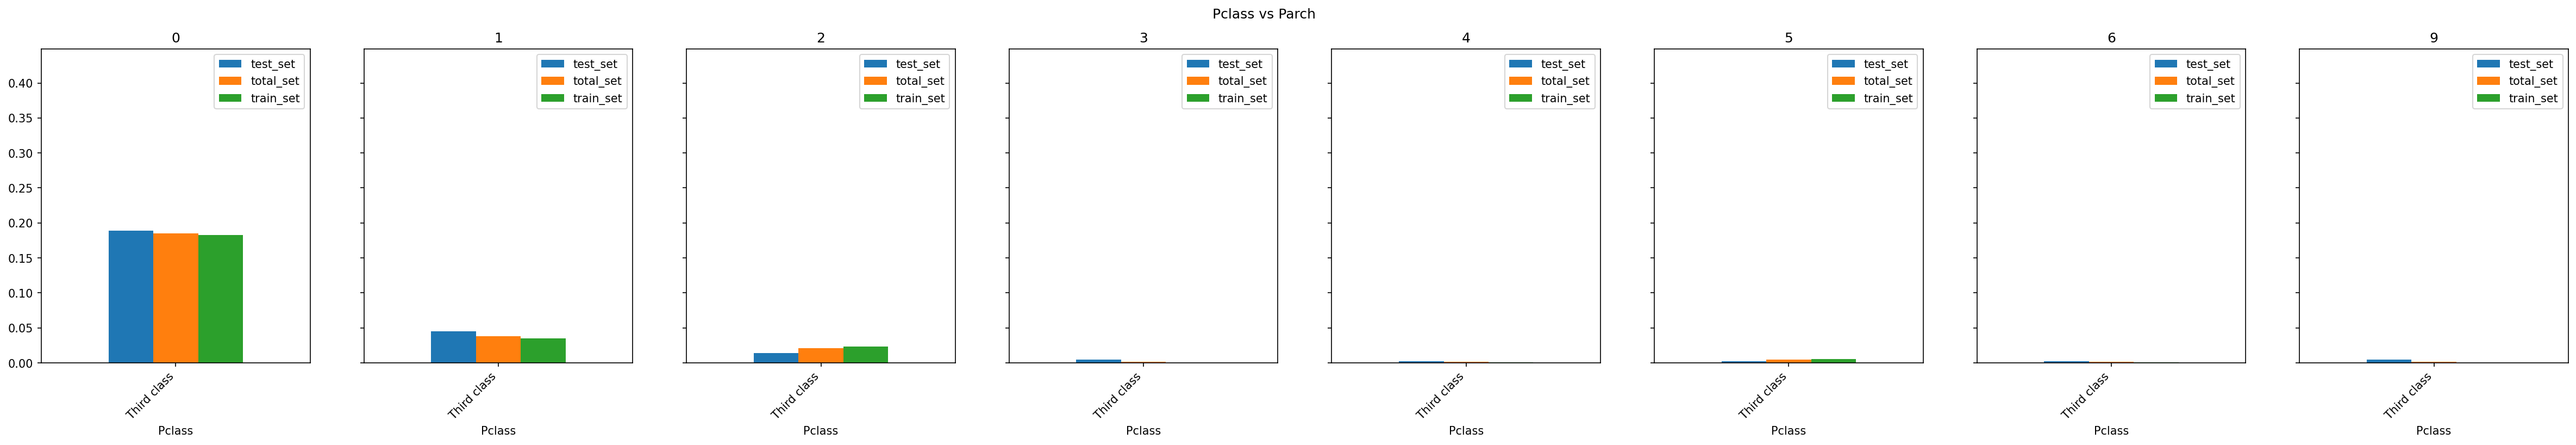

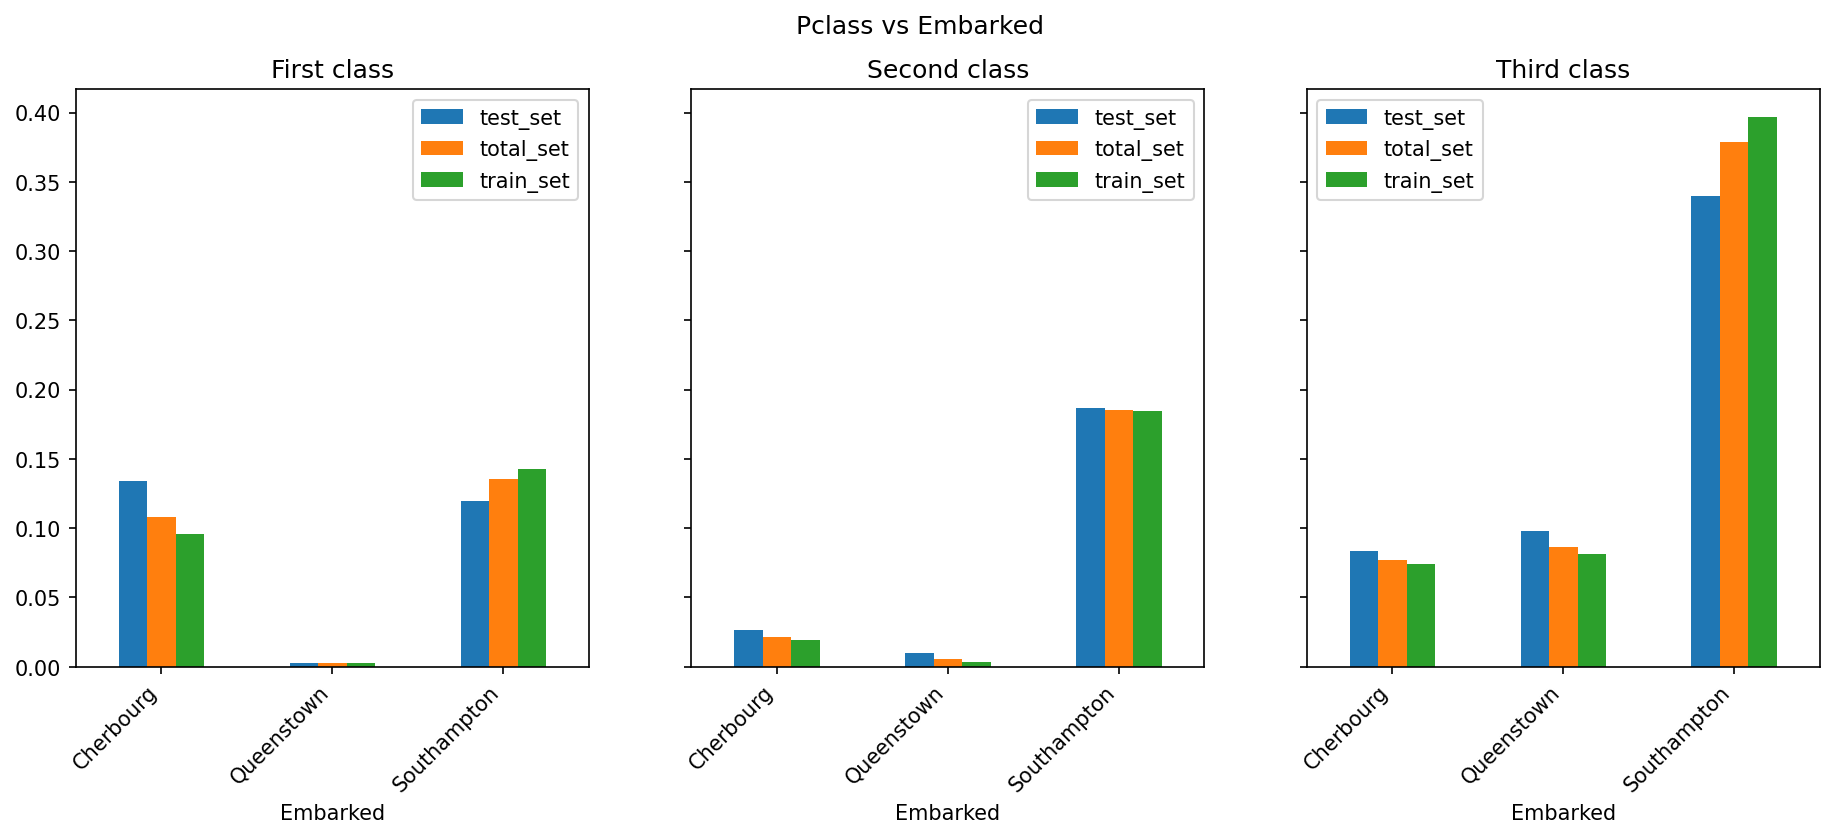

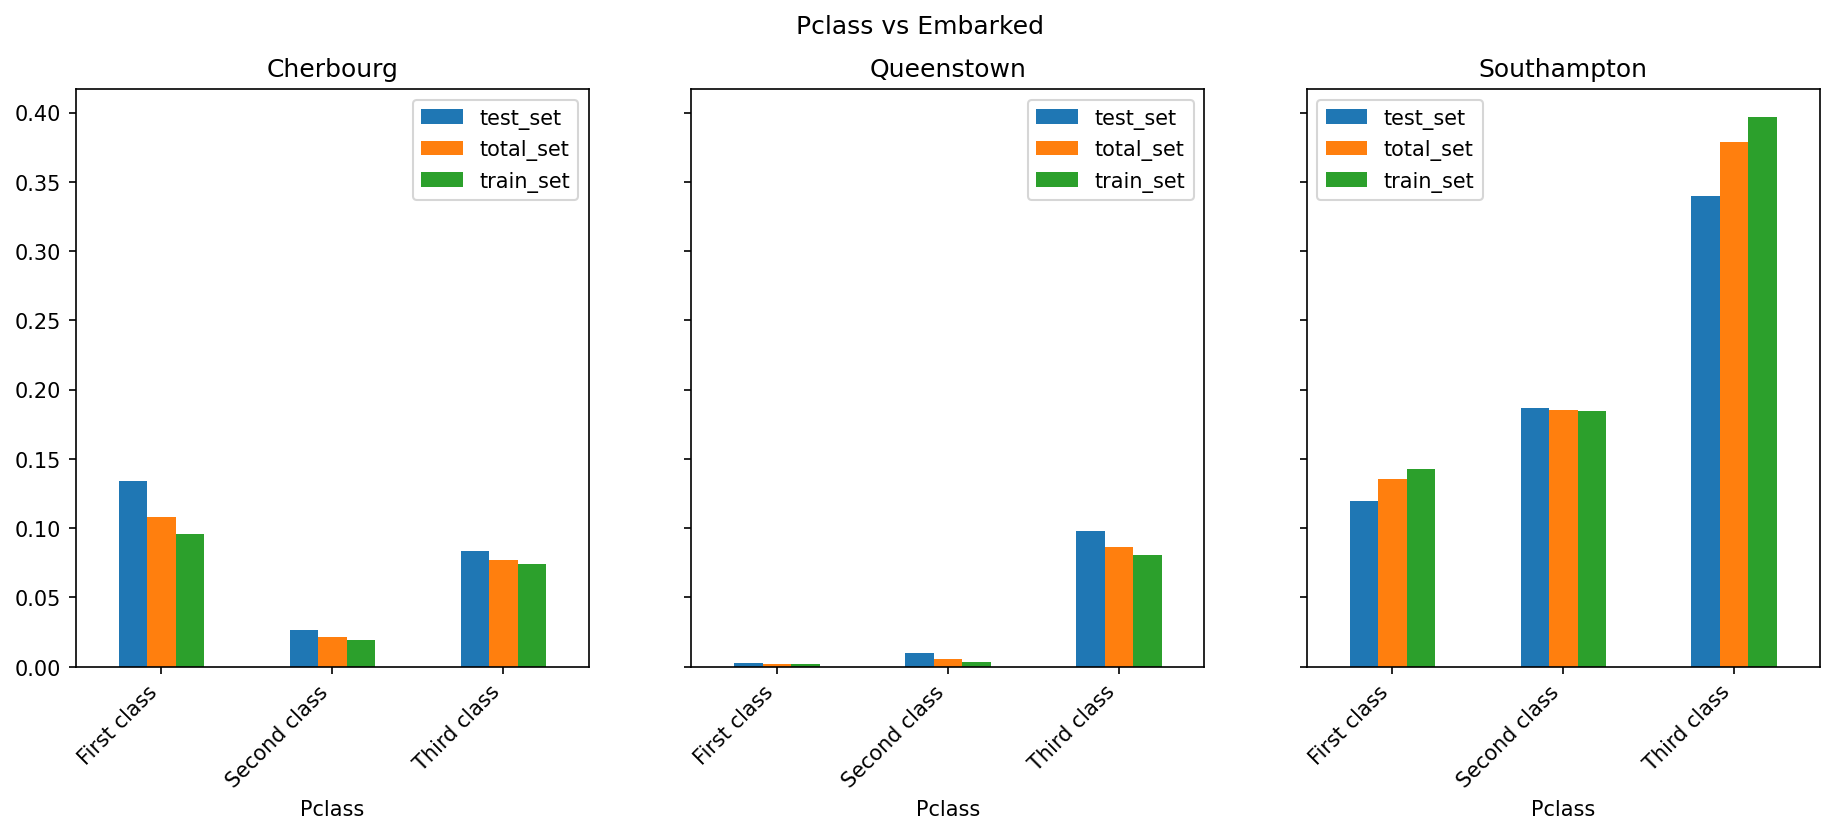

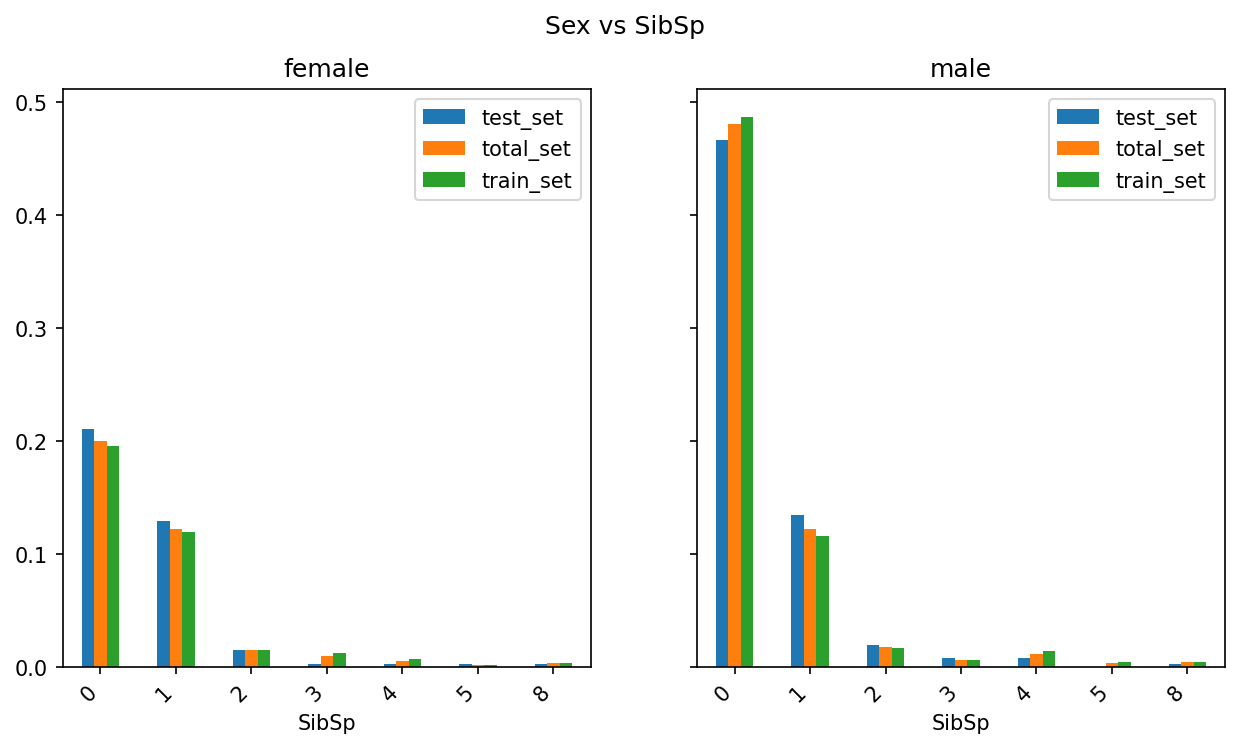

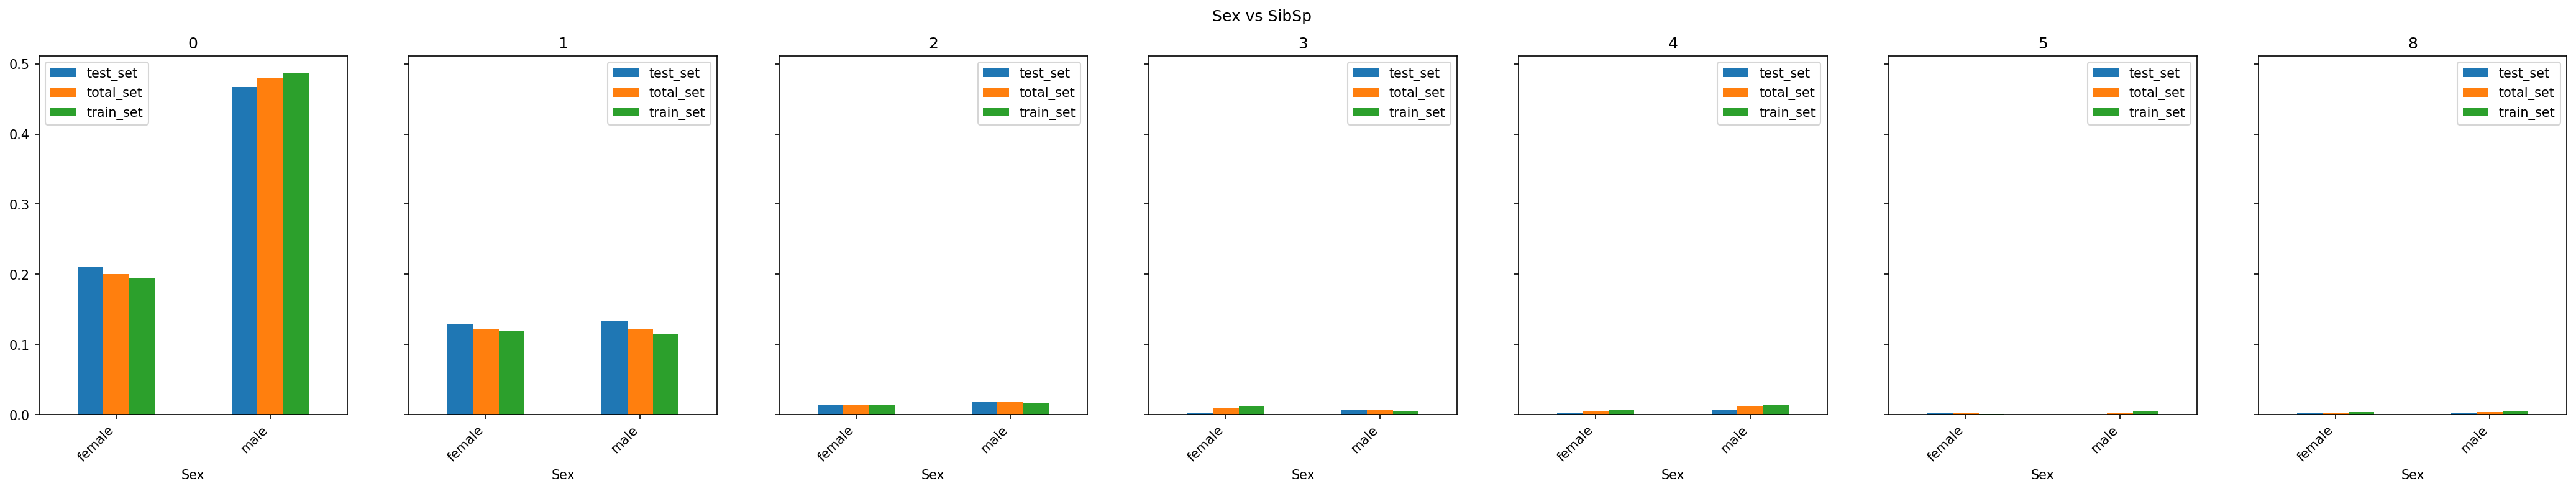

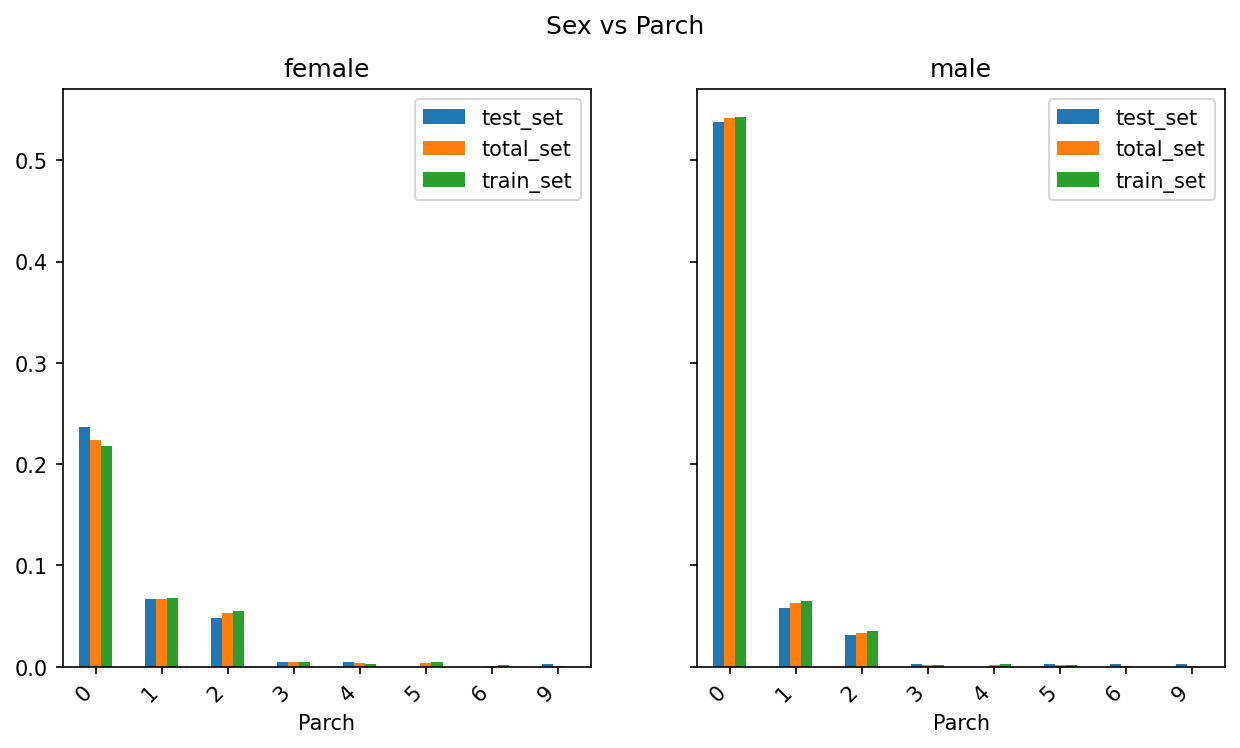

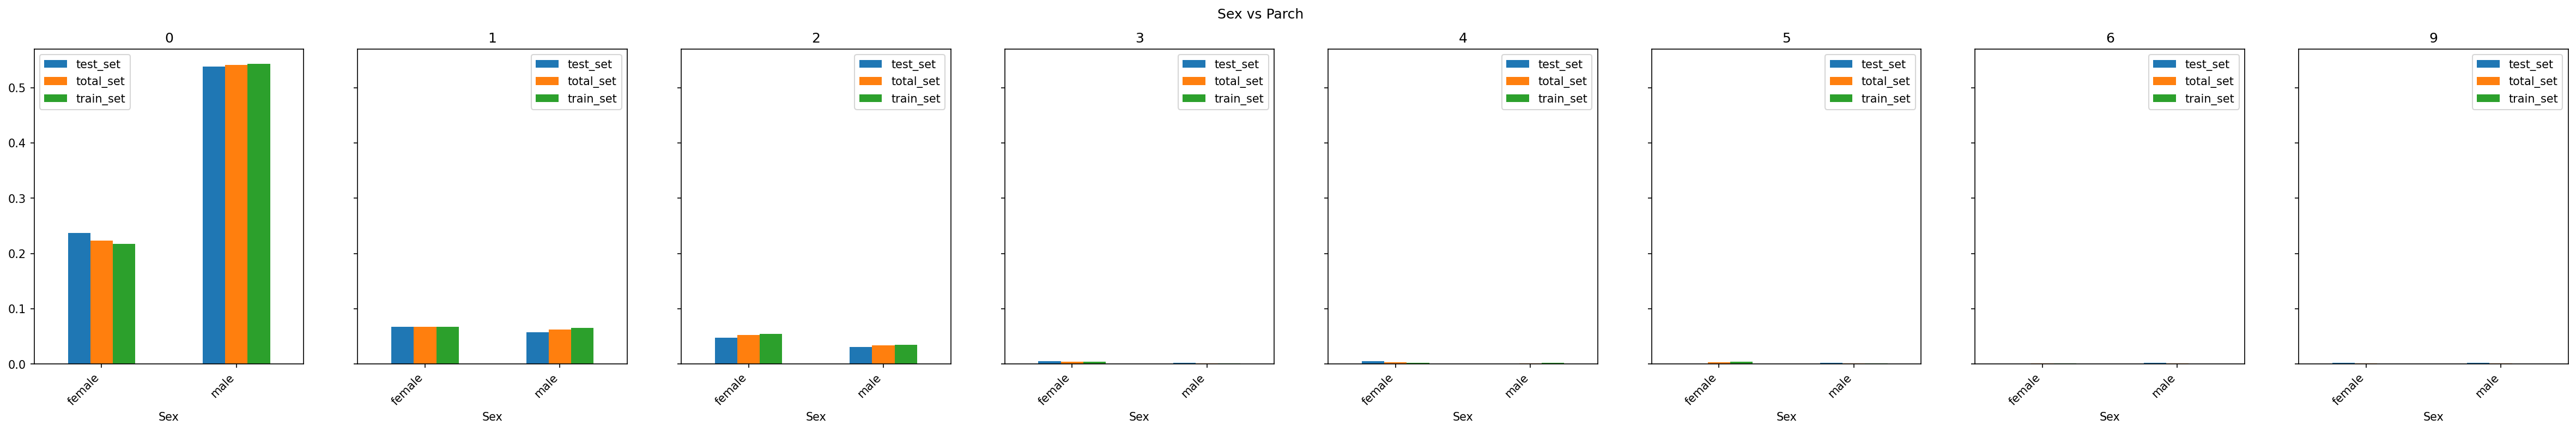

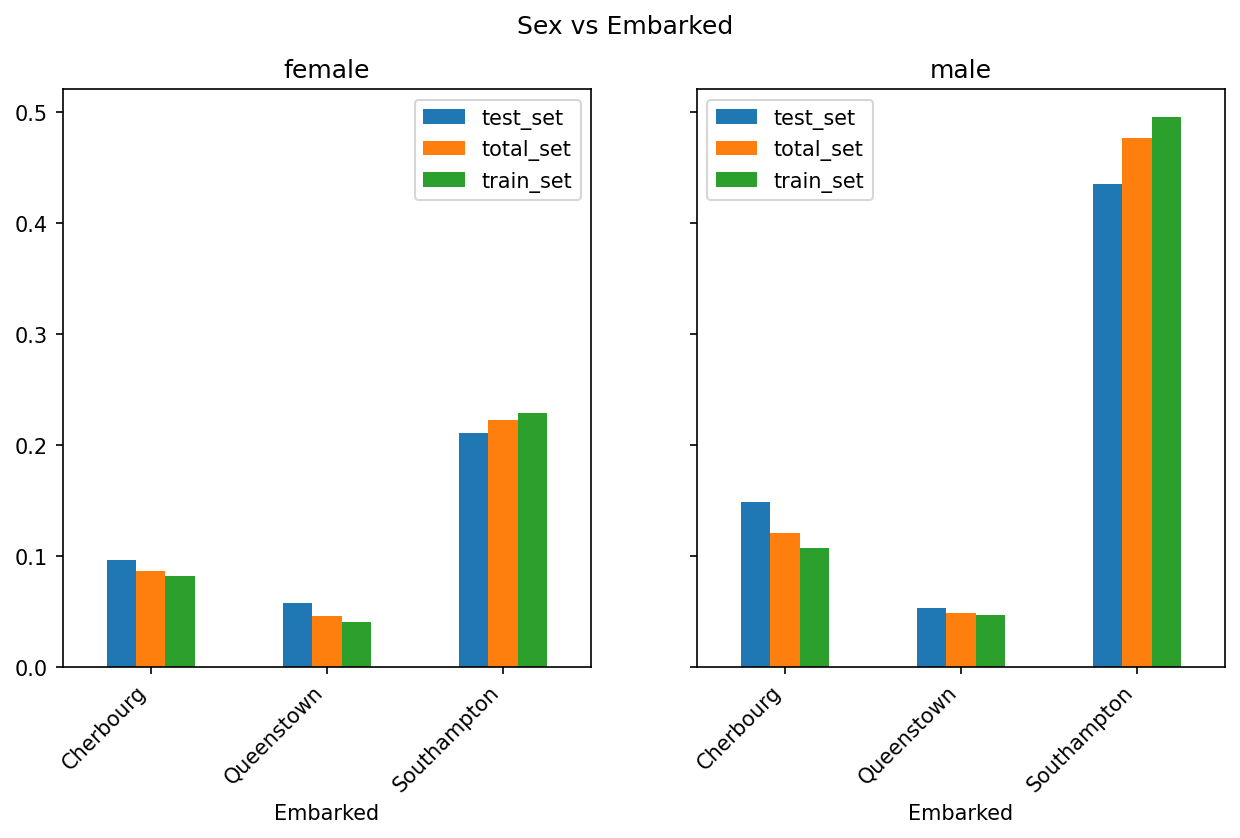

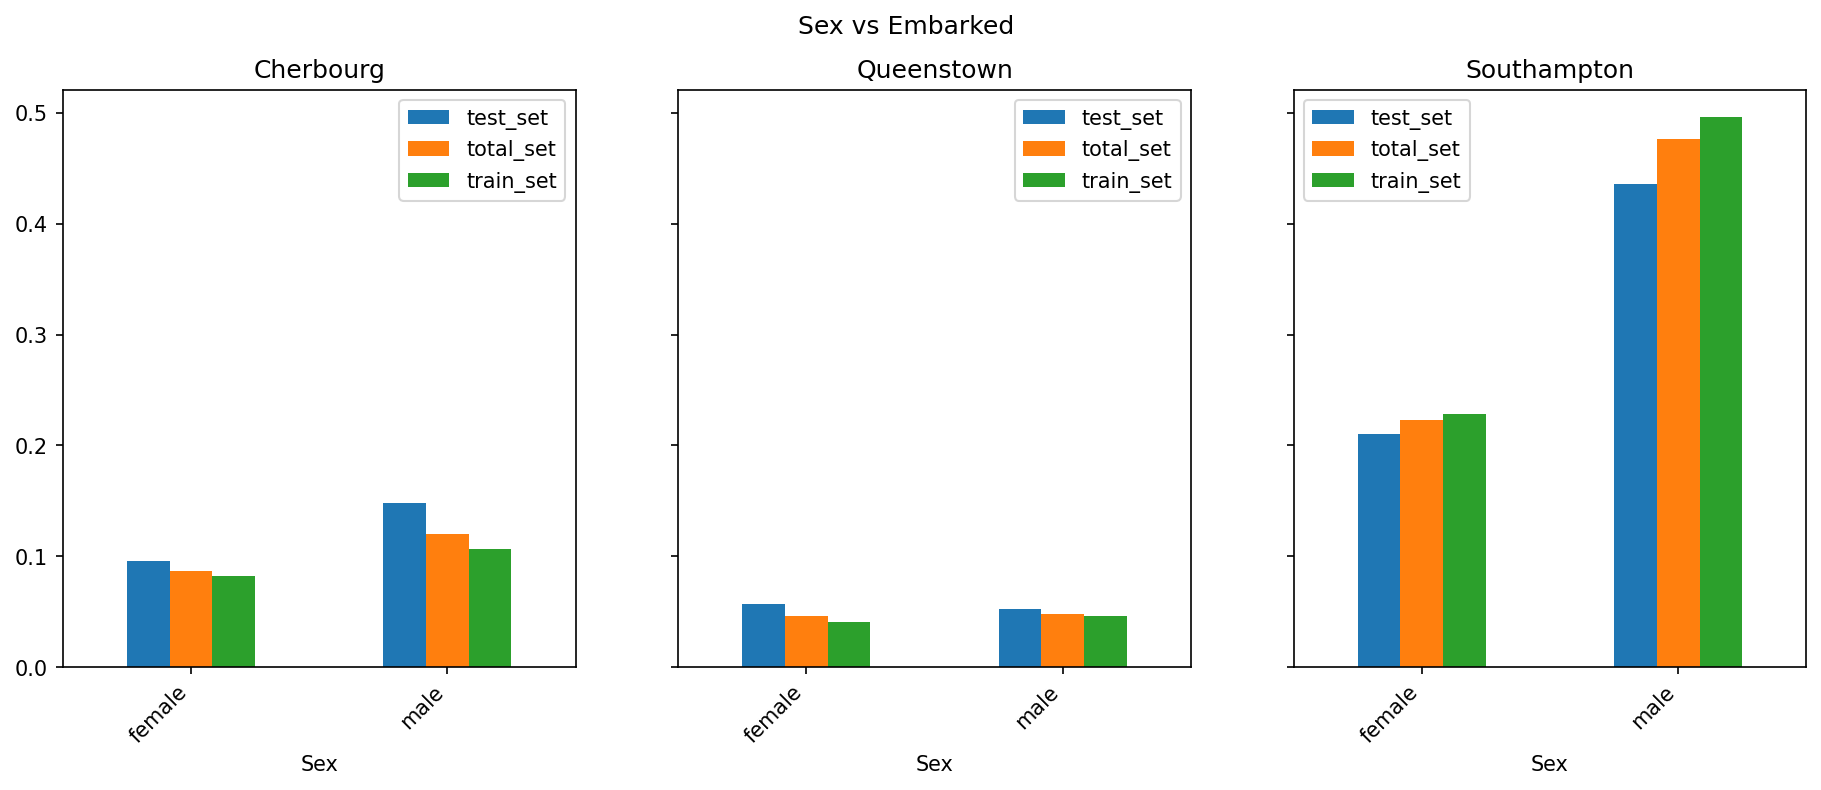

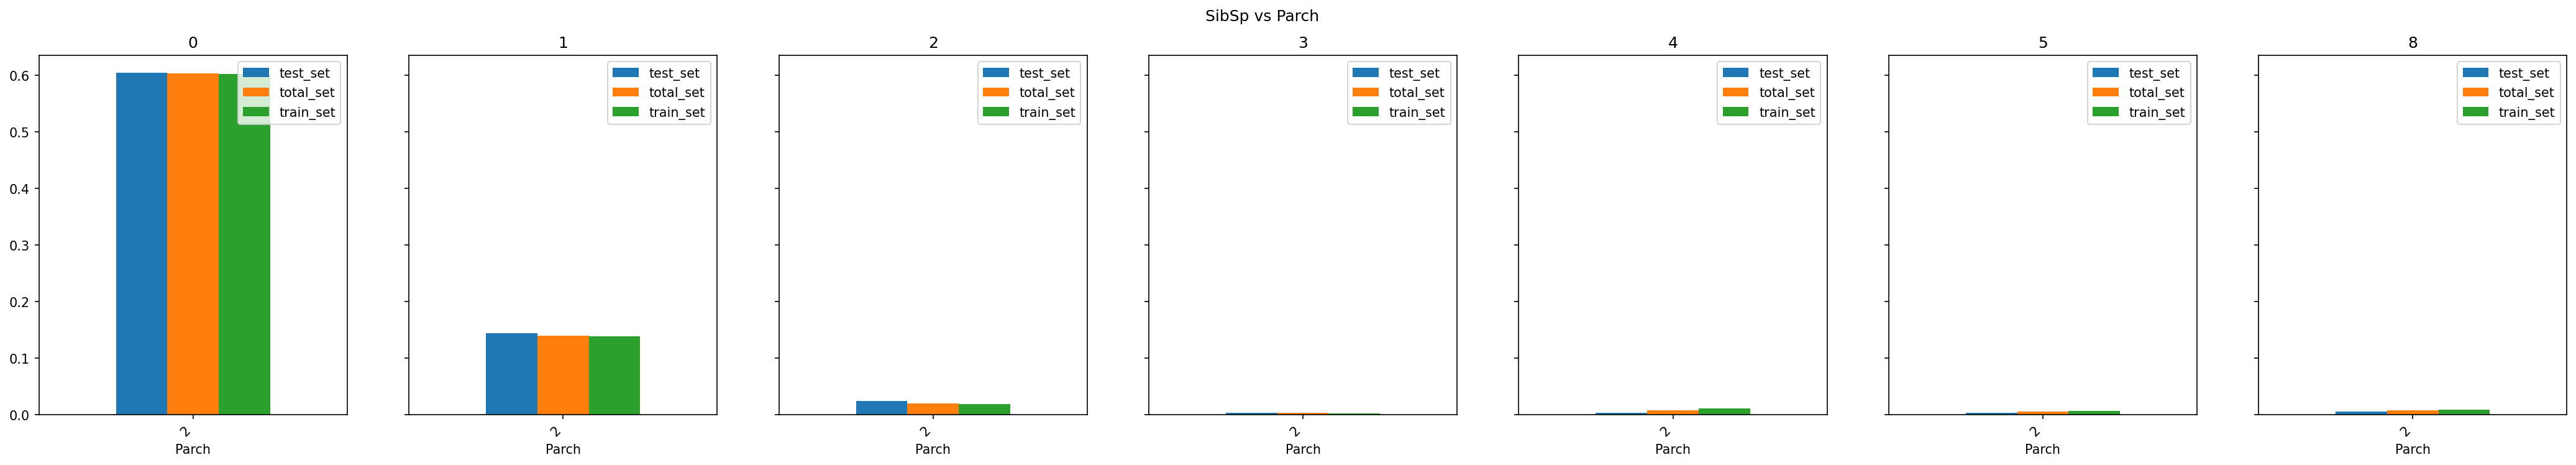

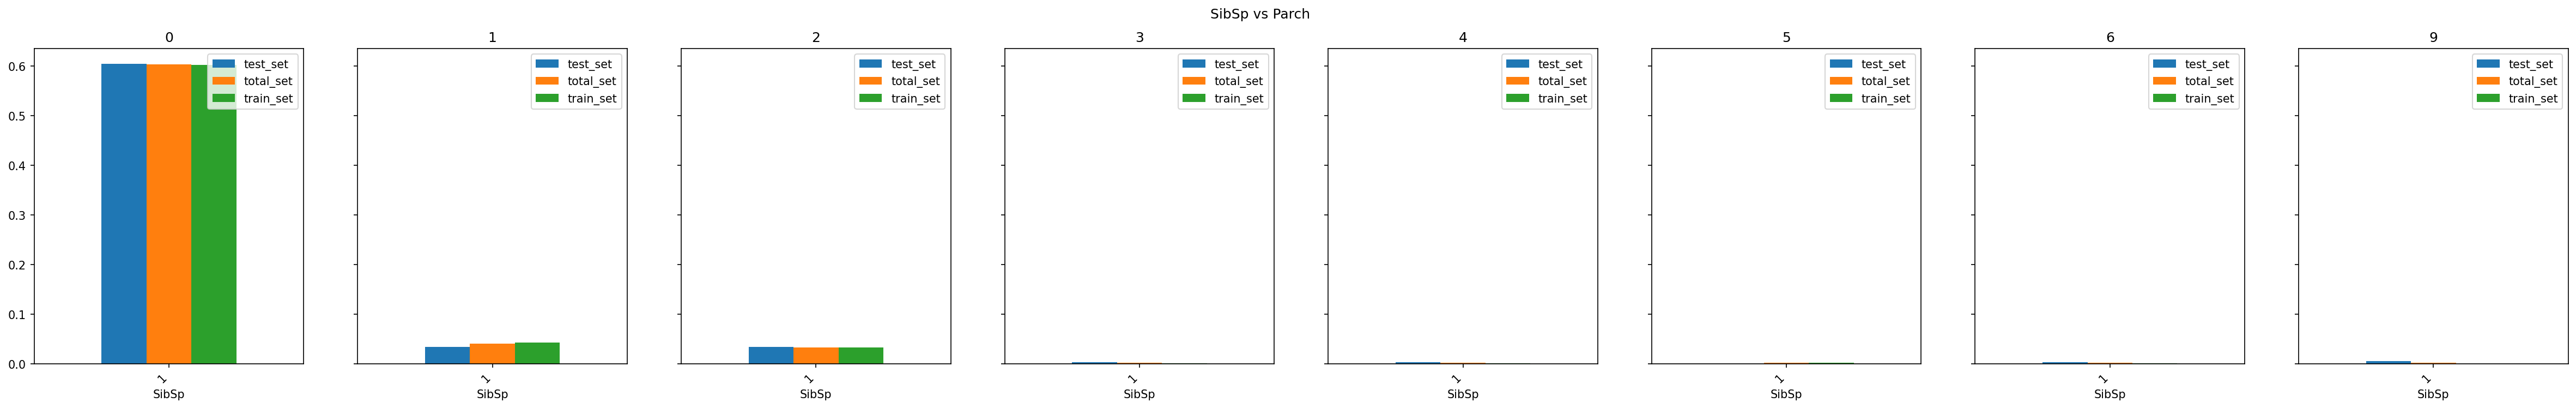

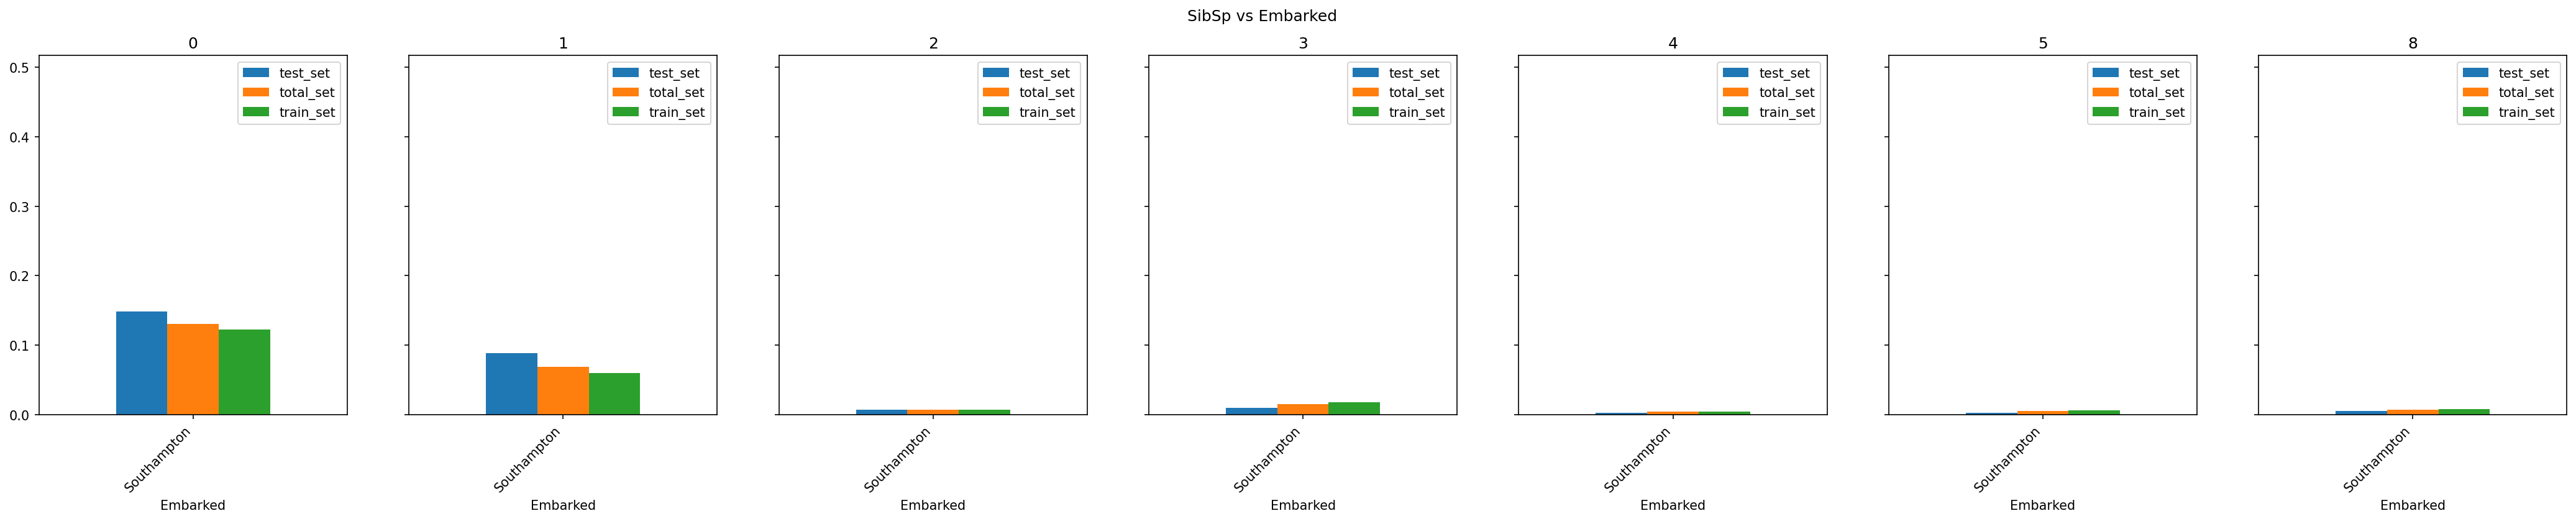

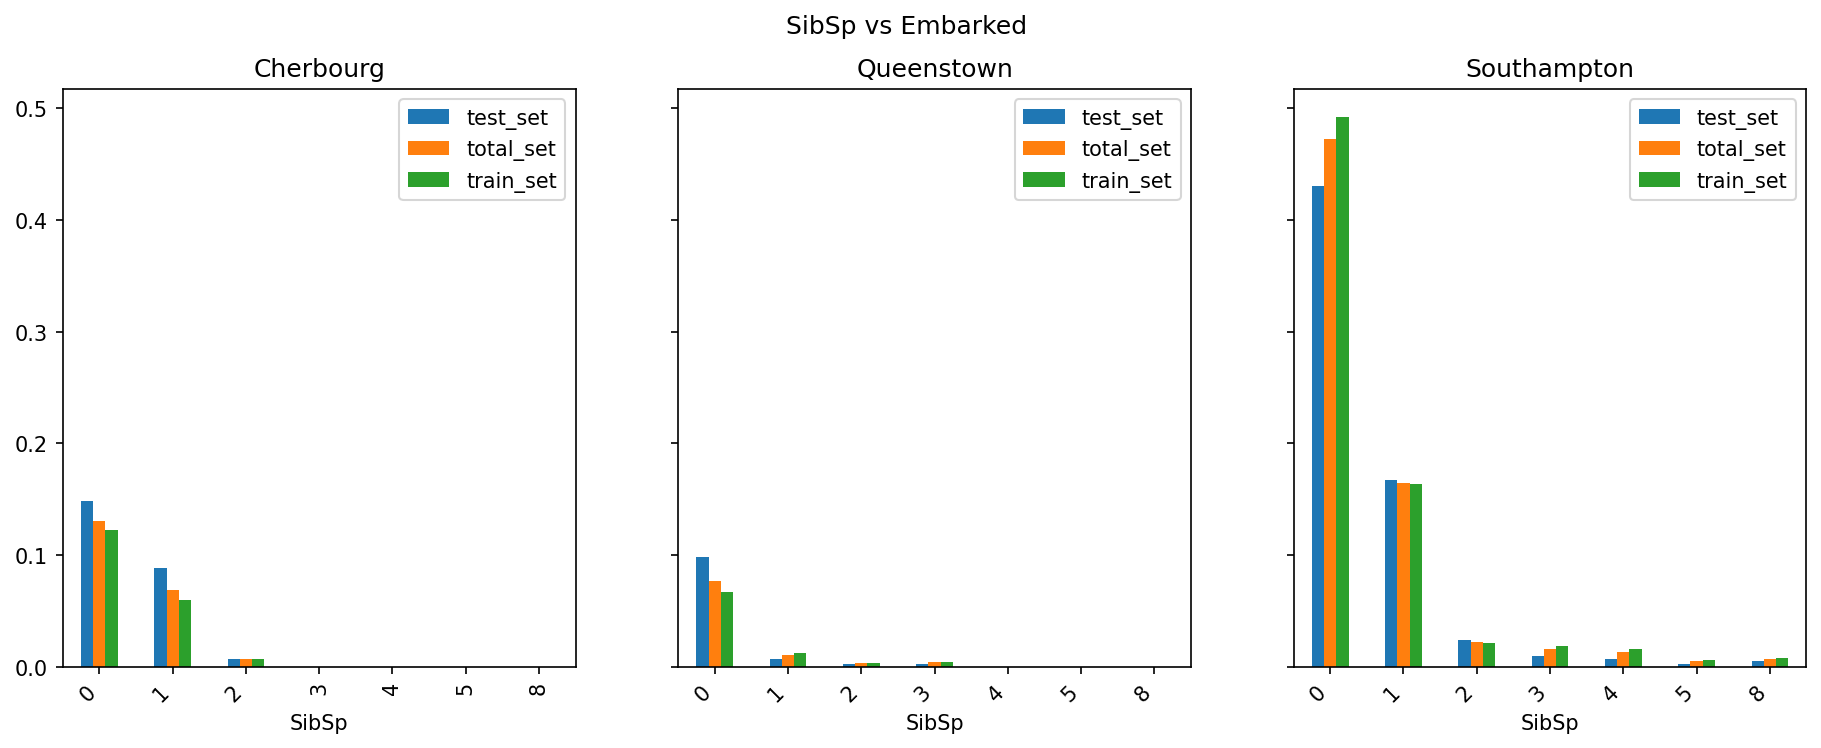

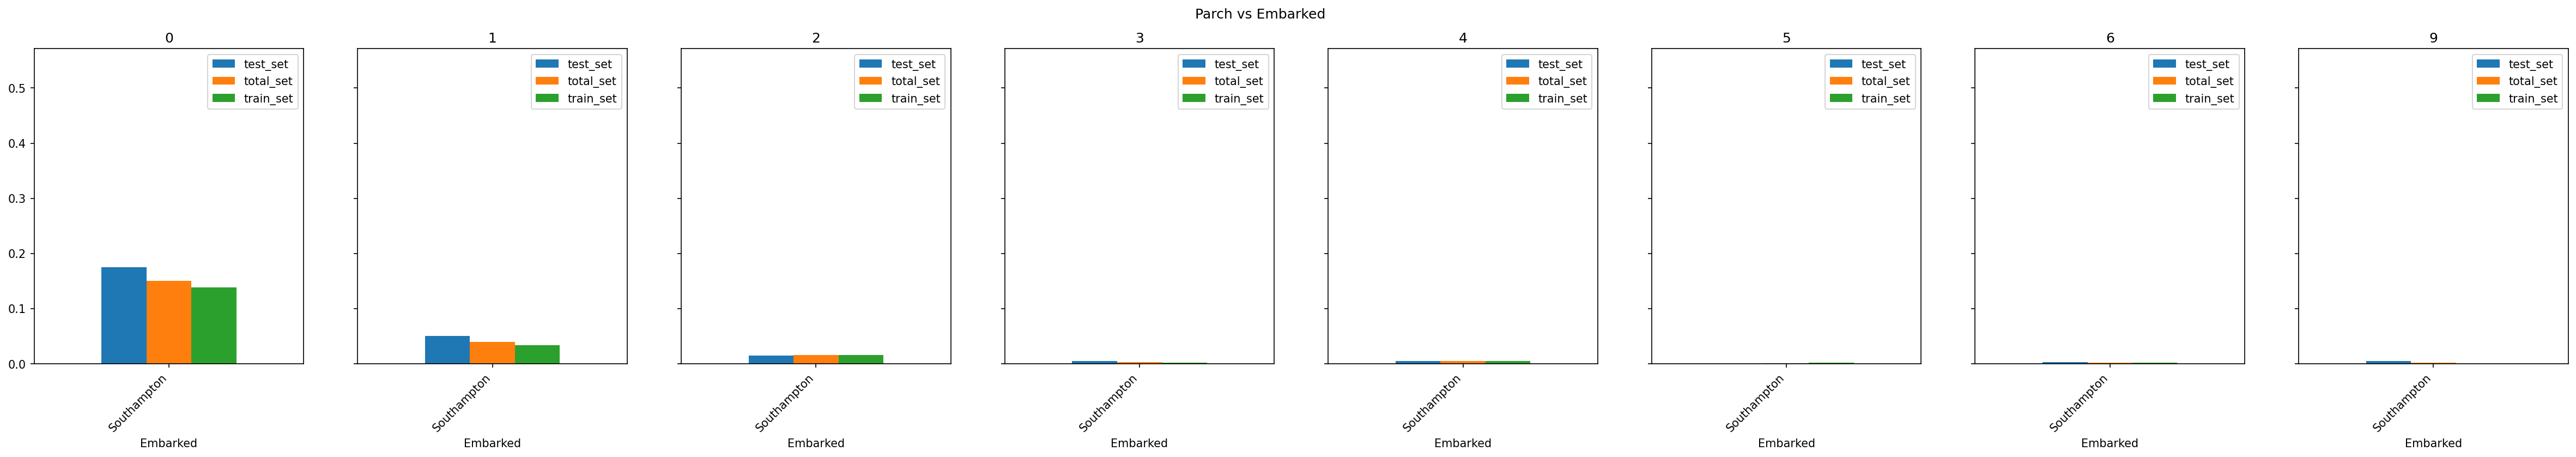

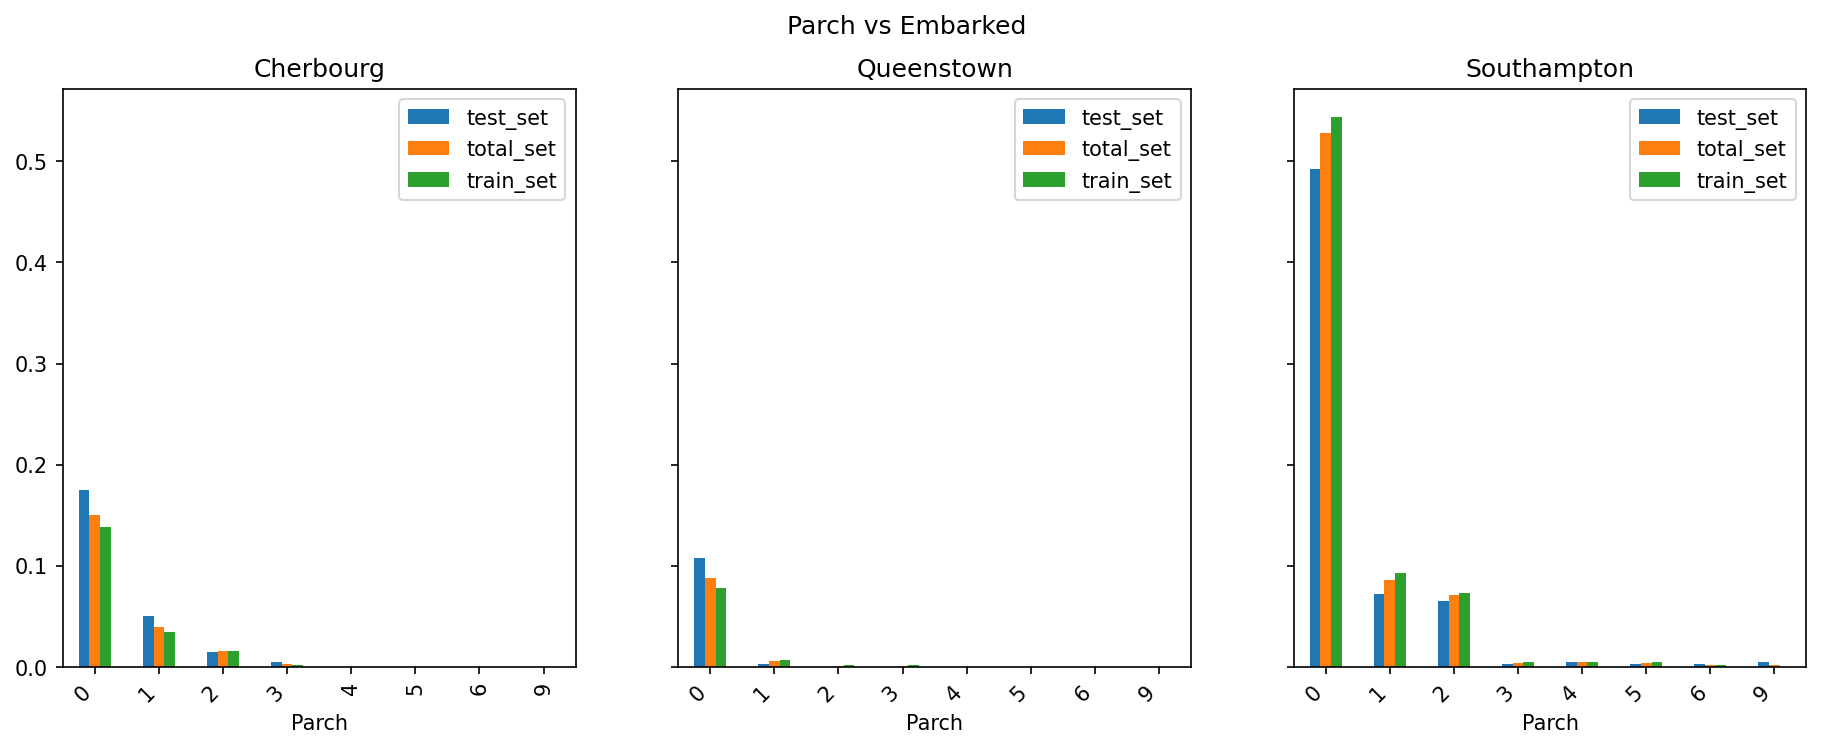

In [200]:
cutoff = 10

# Counts number of unique values in each column to filter with a cut off 
nuniques = total_df.apply(lambda x: x.nunique())
small_catergories = nuniques[nuniques < cutoff].keys()

# Make all combinations to plot against each other
small_catergories_permutations = combinations(small_catergories, 2)
for permutation in small_catergories_permutations:
    permutation = list(permutation)
    survived_percent = total_df.groupby(level=0)[permutation].value_counts(normalize=True)
    unstacked_df = survived_percent.unstack(level=0)
    for i in range(2):
        df_dict = {k: v.droplevel(permutation[i]) for k, v in unstacked_df.groupby(permutation[i])}
        fig, axes = plt.subplots(1, len(df_dict), figsize = (5*len(df_dict), 5), sharex=True, sharey=True)
        fig.suptitle(f'{" vs ".join(permutation)}')
        for ax, (group_value, df) in zip(axes.tolist(), df_dict.items()):
            df.plot(kind = 'bar', ax = ax)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha = 'right')
            ax.set_title(f'{group_value}')
            
            

# Numerical values (Age, Sibsp, Parch, Fare)

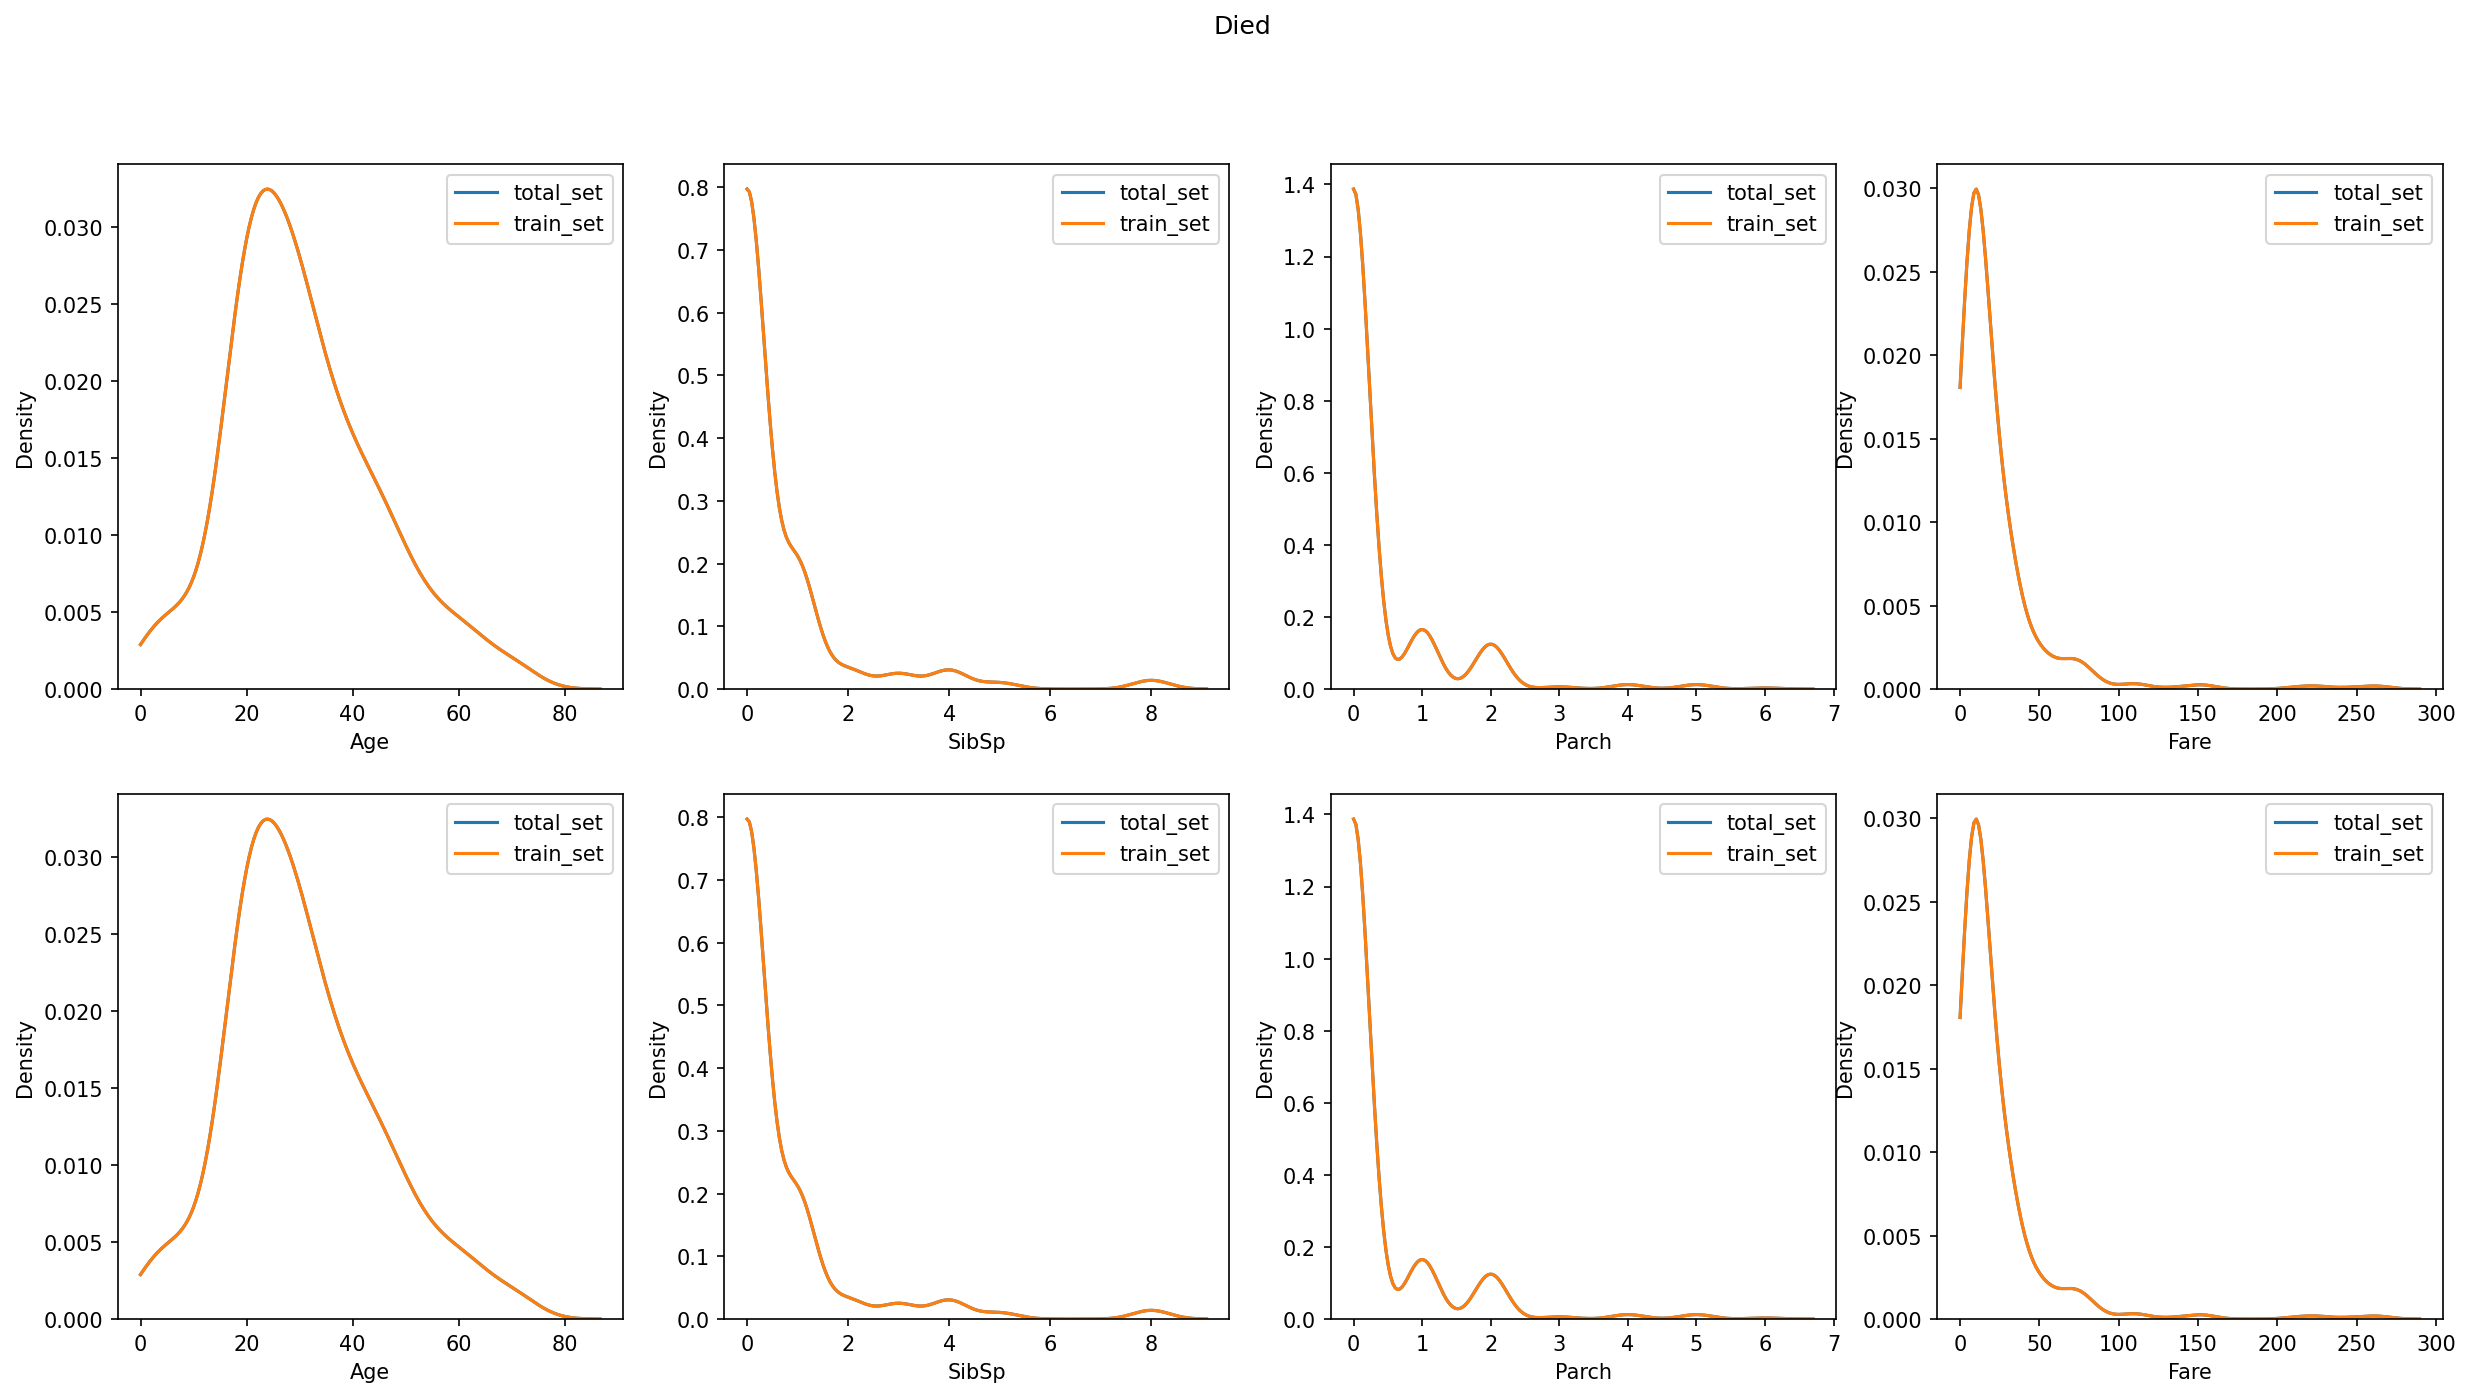

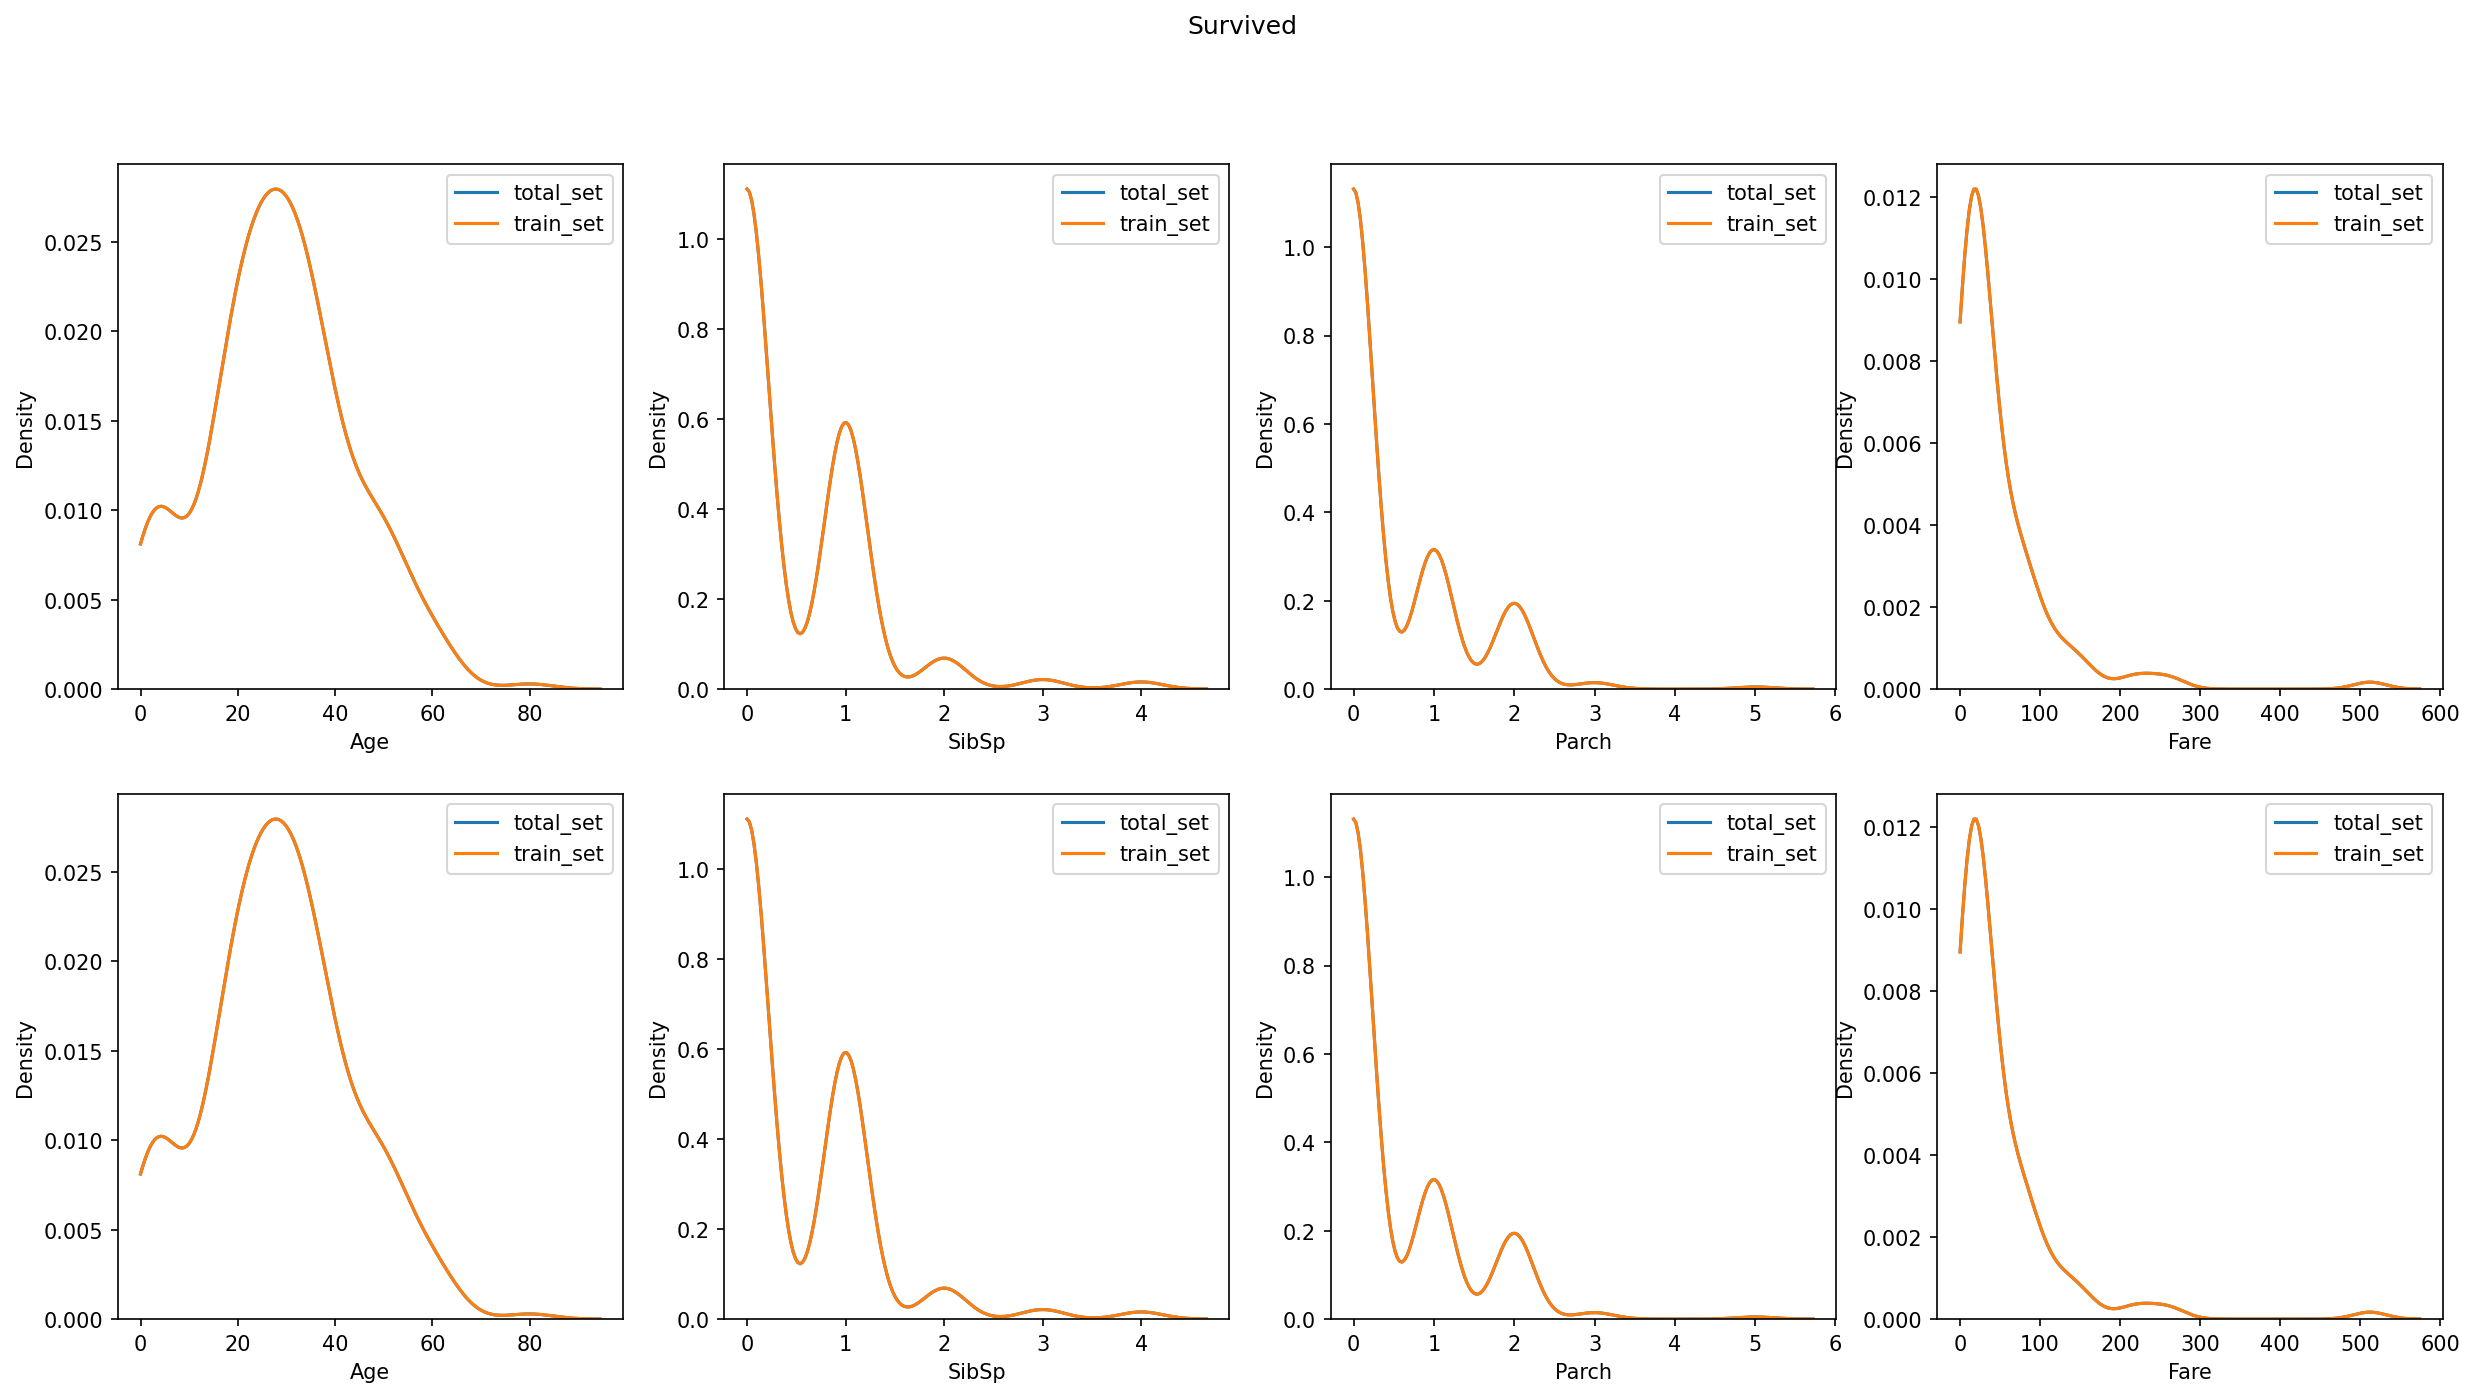

In [201]:
numerical_df = total_df.select_dtypes(include=['float', 'int'])
numerical_cols = numerical_df.columns

numerical_df['Survived'] = total_df['Survived']

survival_dict = {k: v.drop(labels=['Survived'], axis = 1) for k, v in numerical_df.groupby('Survived')}
for survival_state, df in survival_dict.items():
    
    fig, axes = plt.subplots(len(survival_dict), len(numerical_cols), figsize= (5 * len(numerical_cols), 5*len(survival_dict)))
    fig.suptitle(survival_state)
    groups = df.groupby(level=0)
    for ax_row in axes:
        for name, group in groups:
            group = group.droplevel(0)
            for ax, col in zip(ax_row, numerical_cols):
                series = group[col]
                sns.kdeplot(series, ax=ax, label = name, clip = [0, None])
        [ax.legend() for ax in ax_row]

            

# Altering data 


Inspiration taken from : 
* https://www.kaggle.com/code/gbellport/simple-titanic-data-analysis-w-cabin
* https://medium.com/swlh/ways-to-handle-continous-column-missing-data-its-implementations-4704f52ac9c3

In [225]:
def func(row):
    if not type(row) is list:
        return row
    else:
        cabins = [[x[0], int(x[1:])] for x in row if x[0].isalpha() and x[1:].isnumeric()]
        cabin_letter = list(set([cabin[0] for cabin in cabins]))
        try:
            cabin_mean = sum([cabin[1] for cabin in cabins]) / len(cabins)
            return f'{cabin_letter[0]},{cabin_mean}'
        
        except:
            return np.NaN
        
def replace_na_with_sample(x):
    counts = x.value_counts(normalize=True)
    if counts.sum():
        values = counts.index
        p = counts.values
        to_replace = x.isna()
        x[to_replace] = np.random.choice(values, size = to_replace.sum(), p = p)
    return x  

def replace_na_with_mean(x):
    return x.fillna(x.mean())

def imputations_by_categories(df, **kwargs):
    filled_columns = kwargs['filled_columns']
    categories = kwargs['categories']
    funcs = kwargs['replace_funcs']
    replace_methods = kwargs['replace_methods']
    for column, func, replace_method in zip(categories, funcs, replace_methods):
        # +1 needed for walrus
        combination_length = len(filled_columns) + 1
        col = df[column]
        nan_idx = col.isna()
        while (combination_length := combination_length - 1) > 1 and \
            (nan_idx := (col := df[column]).isna()).sum():
            all_combinations = combinations(filled_columns, combination_length)
            col = col.to_frame()
            
            for combination in all_combinations:
                col[combination] = df.groupby(level = 0)\
                    .apply(lambda x: x.groupby(list(combination), group_keys=False)[column]\
                        .apply(lambda x: func(x))).droplevel(level = 0)
        
        # df[column][nan_idx] = getattr(col[nan_idx], replace_method)(axis = 1)[0]
        replacements = getattr(col[nan_idx], replace_method)(axis = 1)
        if isinstance(replacements, pd.DataFrame):
            replacements = replacements[0]
        filled_columns = filled_columns.union([column])
        col = col.drop(columns = column)
        df[column][nan_idx] = replacements
    return df, filled_columns

In [226]:
# Filling NA cabins with ppl from same ticket
total_df['Cabin'] = total_df.groupby('Ticket', group_keys=False)['Cabin'].apply(lambda x: x.fillna(' '.join(x.unique().astype(str).tolist())))

# If  multiple cabins per row, take average for room number
indiviual_cabins = total_df['Cabin'].str.split(' ')
modified_cabins = indiviual_cabins.apply(func).fillna(False)
split_cabins = modified_cabins.str.split(',', expand=True).rename(columns={i : name for i, name in enumerate(['Deck', 'Room number'])})
split_cabins['Room number'] = split_cabins['Room number'].astype(float)
new_df = total_df.join(split_cabins.rename_axis(total_df.index.names)).drop(columns='Cabin')

# Join Parck and Sibsp into family 
new_df['Family size'] = total_df['SibSp'] + total_df['Parch']
new_df = new_df.drop(columns=['SibSp', 'Parch'])

# Map titles to reduce number of catergories
titles = new_df['Name'].str.extract('([A-Za-z]+)\.')
title_list = [['Miss', 'Ms','Mlle'],
['Mrs', 'Mme'],
['Royal','Don','Dona','Lady','Sir','Countess','Jonkheer'],
['Other','Rev','Major','Col','Capt','Dr']]

new_df['Title'] = titles.replace({key : value for value, *keys in title_list for key in keys})

# Filter data to be imputed
nan_columns = new_df.drop(columns=['Survived', 'Name', 'Ticket']).isna().sum().astype(bool)
filled_columns = nan_columns[~nan_columns].index
nan_columns = nan_columns[nan_columns].index
 

# First impute categorical columns
categories = new_df[nan_columns].select_dtypes(include=['object']).columns
categories = new_df[categories].isna().sum().sort_values().index
new_df[categories] = new_df[categories].astype('category')

new_df, filled_columns = imputations_by_categories(new_df, filled_columns=filled_columns, categories=list(categories) + ['Age', 'Fare'], 
                            replace_funcs = [replace_na_with_sample, replace_na_with_sample, replace_na_with_sample, replace_na_with_mean],
                            replace_methods = ['mode', 'mode','mode', 'mean']
                            )

new_df['Room number'] = new_df.groupby('Deck', group_keys=False)['Room number'].apply(lambda x: x.fillna(x.mean()))

# Update small categories
nuniques = new_df.apply(lambda x: x.nunique())
small_catergories = nuniques[nuniques < cutoff].index
new_df[small_catergories] = new_df[small_catergories].astype('category')

new_df['Age'] = new_df['Age'].round().astype('Int8')

/tmp/ipykernel_322/4133618818.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][nan_idx] = replacements
/tmp/ipykernel_322/4133618818.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][nan_idx] = replacements


Survived       836
Pclass           0
Name             0
Sex              0
Age              0
Ticket           0
Fare             0
Embarked         0
Deck             0
Room number      0
Family size      0
Title            0
dtype: int64

# Training the data

In [228]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

LE = LabelEncoder()

train_df = new_df.select_dtypes(exclude=['object'])
train_df['Age'] = train_df['Age'].astype('int')
train_set = train_df.loc['train_set']
variables = train_set.drop(['Survived'], axis = 1)
test_df = train_df.loc['test_set']

LE = LE.fit(train_set['Survived'])
train_labels = LE.transform(train_set['Survived'])


X_train, X_test, y_train, y_test = train_test_split(variables, train_labels, test_size=0.3, random_state=0)


total_train = xgb.DMatrix(variables, label = train_labels, enable_categorical=True)
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

dm_test = xgb.DMatrix(test_df.drop(['Survived'], axis = 1), enable_categorical=True)
# dm_test.shape, dtrain.shape

params = {
    'booster' : 'gbtree',
    'objective':'reg:logistic',
    'max_depth' : 50,
    'eval_metric' : 'error',
}

xgmodel = xgb.train(params, dtrain = dtrain, num_boost_round = 500, evals = [(dtest, 'Test')], early_stopping_rounds = 200, verbose_eval=False)
total_model = xgb.train(params, dtrain = total_train)

for x_vars, y_true, model in zip([dtest, total_train], [y_test, train_labels], [xgmodel, total_model]):
    print(model.best_iteration)
    y_pred = model.predict(x_vars)
    classification = np.where(y_pred < 0.5, 0, 1)
    print(f'''MSE: {mean_squared_error(y_true, y_pred):.4f}, Incorrect_count : {np.sum((y_true - classification)**2)}, Total : {classification.shape[0]},
        Accuracy : {accuracy_score(y_true, classification):.4f}
        ''')

models_pred = np.array([model.predict(dm_test) for model in [xgmodel, total_model]])

pred_df = pd.DataFrame(data = np.where(models_pred < 0.5, 0, 1).T)


0
MSE: 0.1396, Incorrect_count : 49, Total : 268,
        Accuracy : 0.8172
        
9
MSE: 0.0516, Incorrect_count : 61, Total : 891,
        Accuracy : 0.9315
        


In [229]:
# To hand in on kaggle
if not os.path.isdir('submissions'):
  os.mkdir('submissions')
for i, col in enumerate(pred_df.values.T):
  df = test_set['PassengerId'].to_frame()
  df['Survived'] = col
  df.to_csv(f'submissions/Submission_{i}_without_iteration_range.csv', index=False)

# Using XGBoost allows for categorical data without one hot or ordinal encoding implemented by the user. The accuracy is around 77% and 75% for the models trained on the total train data and the partial train data respectively.

## Drawback of ordinal is the inherent addition of an order

### (Red, Green, Blue) -> (0,1,2)

In [231]:
x = new_df.drop('Survived', axis = 1)
x_ohe = pd.get_dummies(x)

# No neat method found
categorical_cols = x.select_dtypes(include = ['category']).columns
x_oe = x.select_dtypes(exclude = ['category'])
for col in categorical_cols:
    x_oe[col] = pd.factorize(x[col])[0]
y = LE.transform(new_df.loc['train_set']['Survived'])

In [234]:
# Trying some classifiers from sklearn
from sklearn.ensemble import (AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier,
                              RandomForestClassifier, HistGradientBoostingClassifier)
from sklearn.gaussian_process import GaussianProcessClassifier 
from sklearn.linear_model import PassiveAggressiveClassifier, RidgeClassifierCV, SGDClassifier, SGDOneClassSVM
from sklearn.neural_network import MLPClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

models = [AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, HistGradientBoostingClassifier,
          GaussianProcessClassifier, PassiveAggressiveClassifier, RidgeClassifierCV, SGDClassifier, SGDOneClassSVM, 
          MLPClassifier, LabelPropagation, LinearSVC, NuSVC, SVC, DecisionTreeClassifier, ExtraTreeClassifier]


for model in models:
    
    trained_model = model().fit(x_ohe.loc['train_set'], y)
    y_pred = trained_model.predict(x_ohe.loc['train_set'])
    classification = np.where(y_pred < 0.5, 0, 1)
    
    print(f'''{model.__name__}\n
MSE: {mean_squared_error(y, y_pred):.4f}
Incorrect_count : {np.sum((y - classification)**2)}
Total : {classification.shape[0]}
Accuracy : {accuracy_score(y, classification):.4f}
''')
    df = test_set['PassengerId'].to_frame()
    df['Survived'] = trained_model.predict(x_ohe.loc['test_set'])
    df.to_csv(f'submissions/Submission_{model.__name__}.csv', index=False)

AdaBoostClassifier

MSE: 0.1336
Incorrect_count : 119
Total : 891
Accuracy : 0.8664

ExtraTreesClassifier

MSE: 0.0000
Incorrect_count : 0
Total : 891
Accuracy : 1.0000

GradientBoostingClassifier

MSE: 0.1448
Incorrect_count : 129
Total : 891
Accuracy : 0.8552

RandomForestClassifier

MSE: 0.0000
Incorrect_count : 0
Total : 891
Accuracy : 1.0000

HistGradientBoostingClassifier

MSE: 0.0224
Incorrect_count : 20
Total : 891
Accuracy : 0.9776

GaussianProcessClassifier

MSE: 0.0011
Incorrect_count : 1
Total : 891
Accuracy : 0.9989

PassiveAggressiveClassifier

MSE: 0.2761
Incorrect_count : 246
Total : 891
Accuracy : 0.7239

RidgeClassifierCV

MSE: 0.0000
Incorrect_count : 0
Total : 891
Accuracy : 1.0000

SGDClassifier

MSE: 0.3345
Incorrect_count : 298
Total : 891
Accuracy : 0.6655

SGDOneClassSVM

MSE: 0.6341
Incorrect_count : 549
Total : 891
Accuracy : 0.3838

MLPClassifier

MSE: 0.0000
Incorrect_count : 0
Total : 891
Accuracy : 1.0000

LabelPropagation

MSE: 0.0000
Incorrect_count : 0

/home/henk/miniconda3/envs/wt-env/lib/python3.10/site-packages/sklearn/semi_supervised/_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/home/henk/miniconda3/envs/wt-env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


NuSVC

MSE: 0.1886
Incorrect_count : 168
Total : 891
Accuracy : 0.8114

SVC

MSE: 0.3221
Incorrect_count : 287
Total : 891
Accuracy : 0.6779

DecisionTreeClassifier

MSE: 0.0000
Incorrect_count : 0
Total : 891
Accuracy : 1.0000

ExtraTreeClassifier

MSE: 0.0000
Incorrect_count : 0
Total : 891
Accuracy : 1.0000

